# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

from vanna.utils import strip_brackets

In [2]:
file_db = "~/Downloads/chinook.sqlite"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [3]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


### Config LLM

In [4]:
model_name = "mistral-nemo" # "qwen2.5" # 'deepseek-coder-v2'
CONFIG = {
    'model': model_name,   
}

class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

vn = MyVanna(config=CONFIG)

In [5]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

vn.run_sql_is_set

True

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [6]:
if clean_and_train:
    vn.remove_collections()

In [7]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [8]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [9]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [10]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)


Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,039f9d54-59f7-5f29-8c04-14dbc3e95671-ddl,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
1,0db84e3d-ef41-563c-803e-21c1b985dc19-ddl,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
2,10cba811-ddba-5042-9e90-d764dfcd1629-ddl,None,"CREATE INDEX IFK_InvoiceCustomerId ON ""invoice...",ddl
3,2c711317-b93d-5f60-a728-cb1c6fcbc040-ddl,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
4,37319c81-65f7-50ee-956b-795de244bee5-ddl,None,"CREATE TABLE sqlite_stat1(tbl,idx,stat)",ddl
5,40bd77cd-e1de-5872-8693-624117ff413c-ddl,None,"CREATE INDEX IFK_InvoiceLineInvoiceId ON ""invo...",ddl
6,41130543-7164-562a-90a7-0fd0a409c154-ddl,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
7,458debc8-8082-5450-a17a-66028bd55ace-ddl,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
8,4815f3fd-925b-53ce-9dfa-0e4285d5abd3-ddl,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
9,48d484e9-984c-58ff-b391-75521c69d486-ddl,None,"CREATE INDEX IFK_PlaylistTrackTrackId ON ""play...",ddl


## Ask AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

```sql

SELECT name FROM sqlite_master WHERE type = 'table';


SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [12]:
ts_start = time()

In [13]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 2:  Can you list all tables in the SQLite database catalog?


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE sqlite_stat1(tbl,idx,stat)\n\nCREATE TABLE sqlite_sequence(name,seq)\n\nCREATE TABLE "playlists"\r\n(\r\n    PlaylistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(120)\r\n)\n\nCREATE TABLE "genres"\r\n(\r\n    GenreId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(120)\r\n)\n\nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10

SELECT name FROM sqlite_master WHERE type='table'


[( DATA )]
queried dataframe


,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if df.shape[0] == 1:
    fig = px.indicator(df, title='Tables', color='name')
else:
    fig = px.bar(df, x=0, y=1, title='Tables')

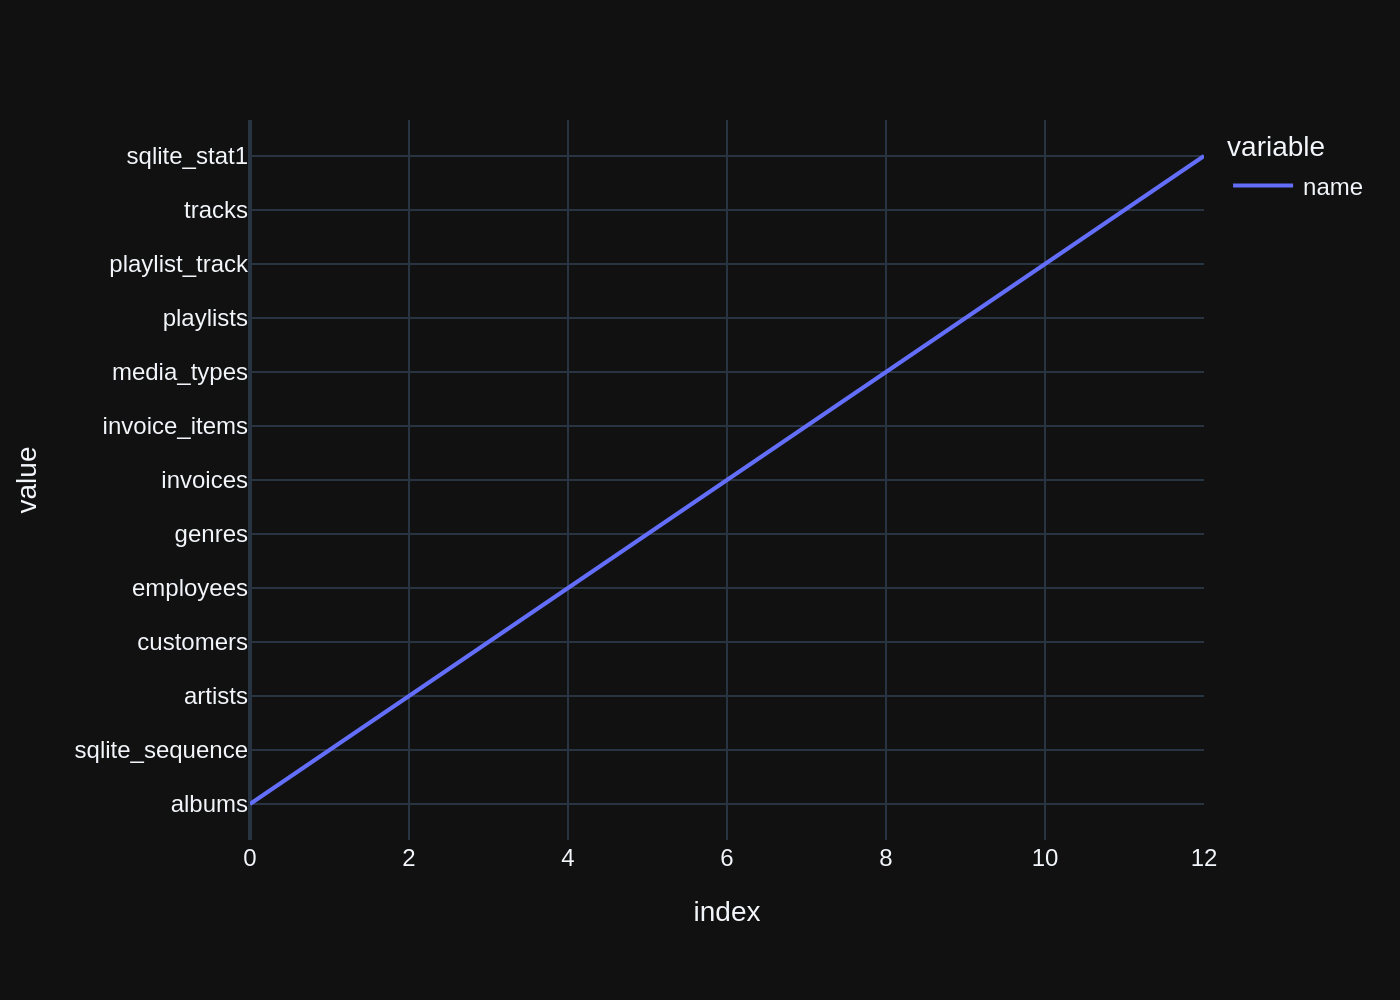

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 3:  which table stores customer's orders


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( LLM Response )]
invoices

[( RETRY )]
***** 1 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n 

SELECT name FROM sqlite_master WHERE type='table' AND name='invoices'


[( DATA )]
queried dataframe


,name
0,invoices



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='name', y=[1])

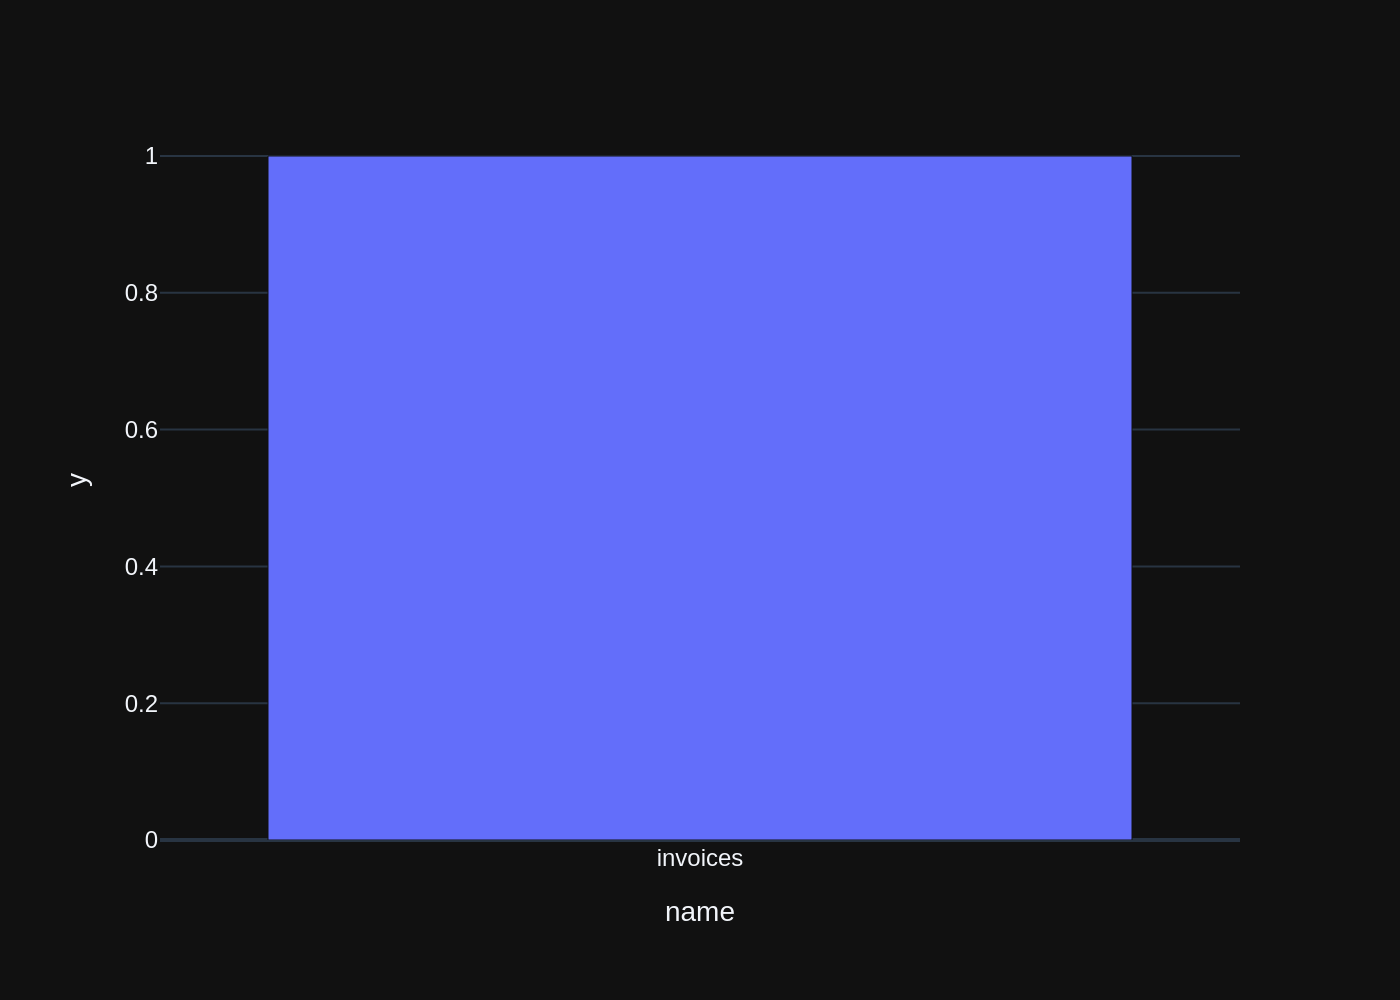

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 4:  How many customers are there


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_CustomerSupportRepId ON "customers" (SupportRepId)\n\nCREATE TABLE "customers"\r\n(\r\n    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    FirstName 

SELECT COUNT(*) FROM customers


[( DATA )]
queried dataframe


,COUNT(*)
0,59



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


if df.shape[0] > 1:
    import plotly.express as px
    fig = px.bar(df, x=0, y='COUNT(*)')
    
else:
    import plotly.graph_objects as go
    fig = go.Figure(go.Indicator(
        mode="number+gauge",
        value=df.iloc[0, 1],
        title={'text': "Customers"}
    ))

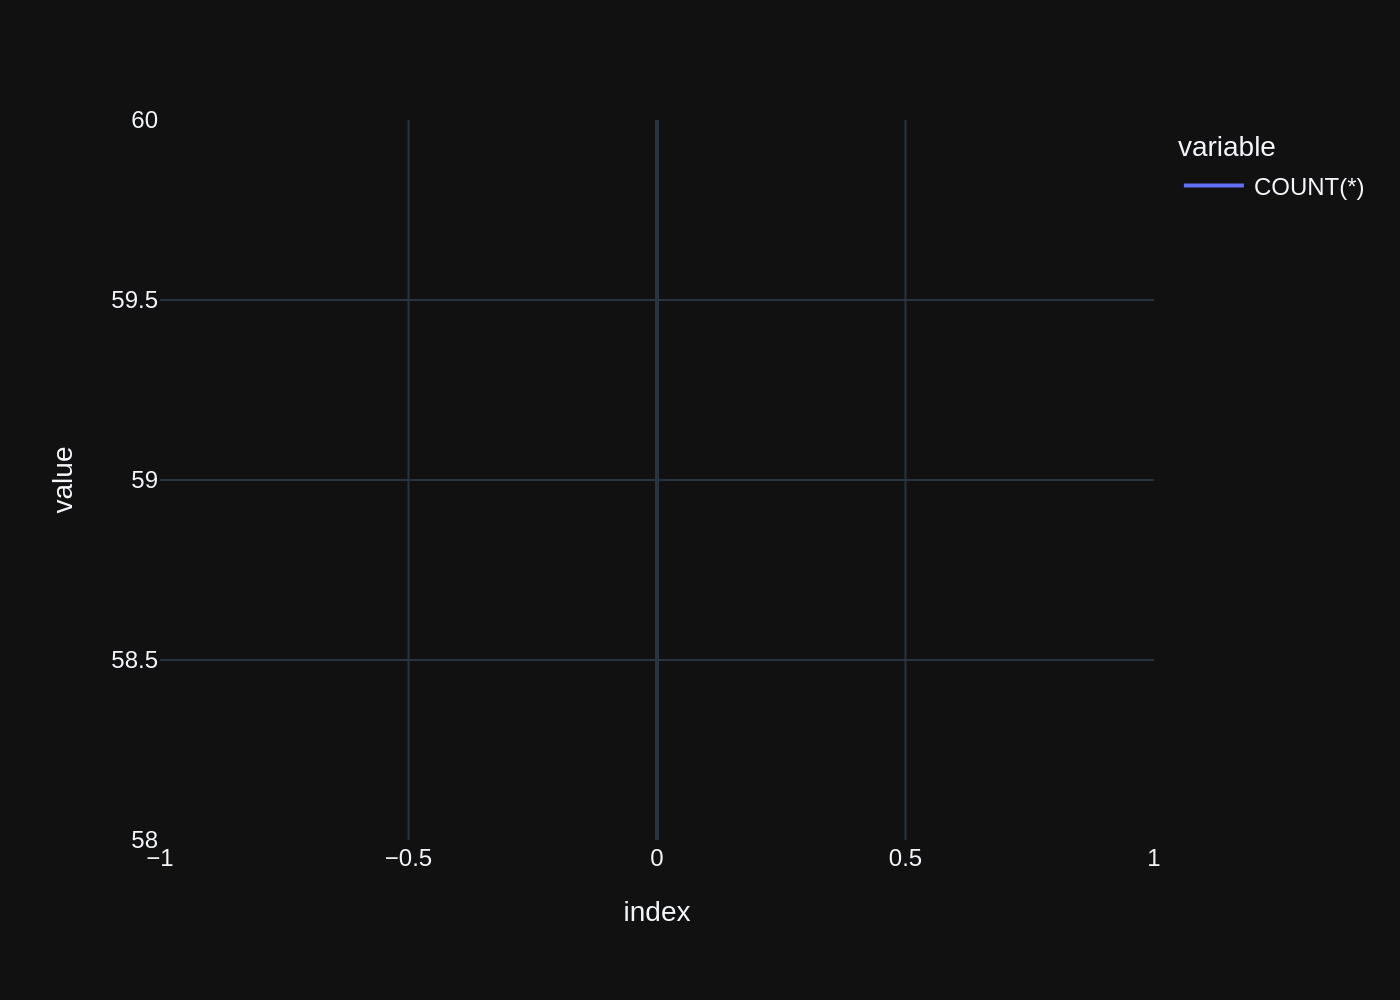

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 5:  what are the top 5 countries that customers come from?


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "customers"\r\n(\r\n    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    FirstName NVARCHAR(40)  NOT NULL,\r\n    LastName NVARC

SELECT country, COUNT(*) as num_customers
FROM customers
GROUP BY country
ORDER BY num_customers DESC
LIMIT 5


[( DATA )]
queried dataframe


,Country,num_customers
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='Country', y='num_customers')

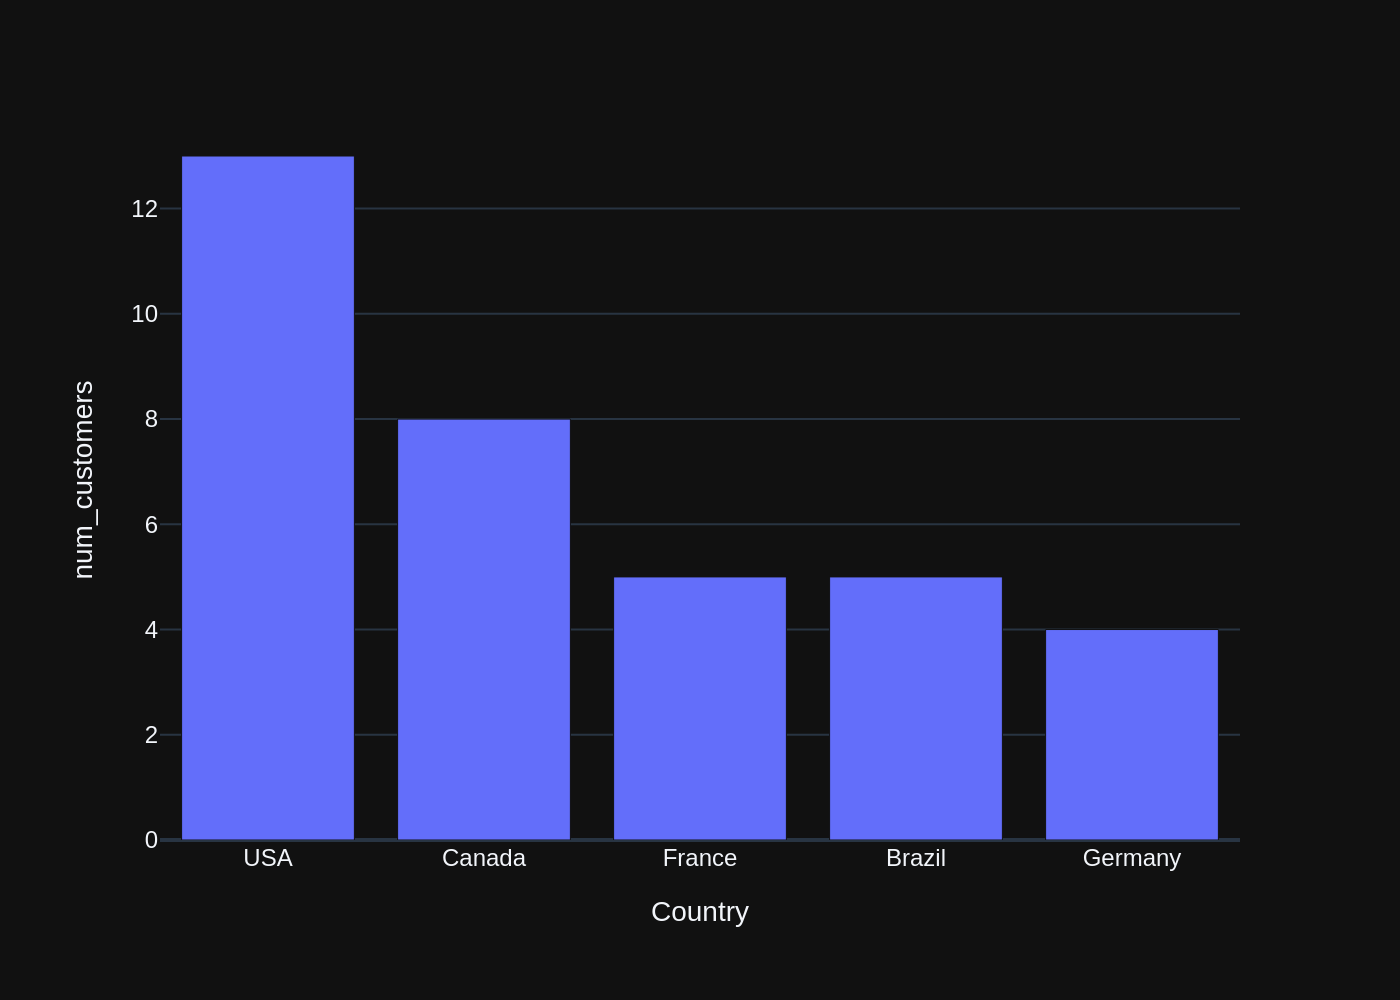

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 6:  List all albums and their corresponding artist names  


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_AlbumArtistId ON "albums" (ArtistId)\n\nCREATE TABLE "albums"\r\n(\r\n    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Title NVARCHAR(160)  NOT NULL,\r\n    ArtistId INTEGER  NOT NULL,\r\n    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(

SELECT a.Title AS AlbumName, ar.Name AS ArtistName FROM albums a JOIN artists ar ON a.ArtistId = ar.ArtistId


[( DATA )]
queried dataframe


,AlbumName,ArtistName
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
...,...,...
342,Respighi:Pines of Rome,Eugene Ormandy
343,Schubert: The Late String Quartets & String Qu...,Emerson String Quartet
344,Monteverdi: L'Orfeo,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon..."
345,Mozart: Chamber Music,Nash Ensemble



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if len(df) > 1:
    fig = px.bar(df, x='ArtistName', y='AlbumName')
    
else:
    fig = px.indicator(title=df['AlbumName'][0], value=1)

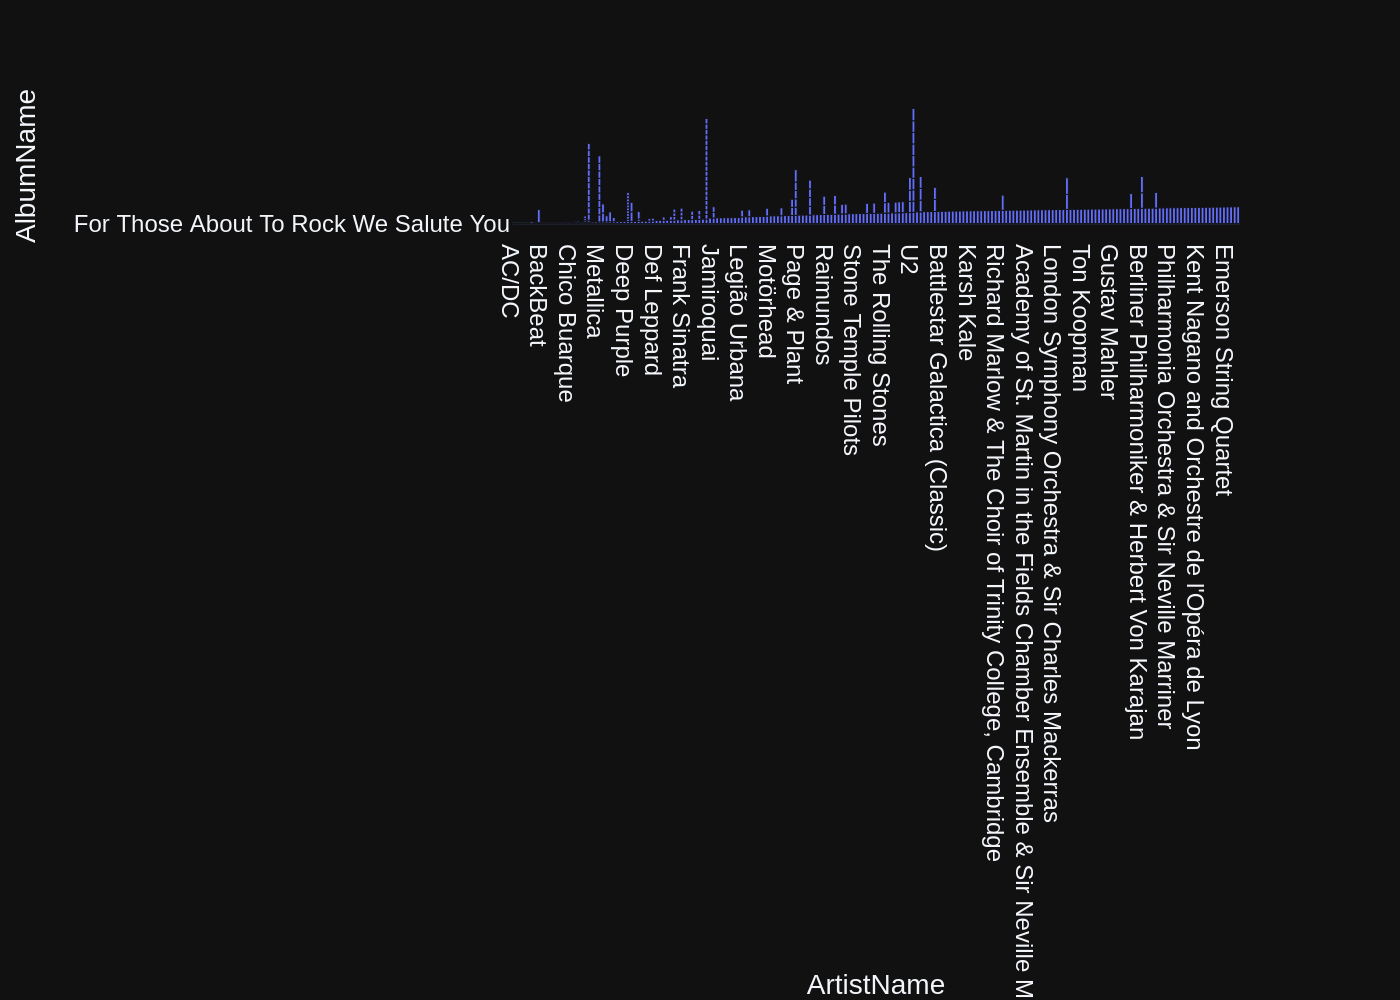

Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 7:  Find all tracks with a name containing "What" (case-insensitive) 


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_TrackGenreId ON "tracks" (GenreId)\n\nCREATE INDEX IFK_PlaylistTrackTrackId ON "playlist_track" (TrackId)\n\nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DE

SELECT * FROM tracks WHERE lower(Name) LIKE '%what%'


[( DATA )]
queried dataframe


,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if len(df) == 1:
    fig = px.indicator(df, title='Track Results')
else:
    fig = px.scatter(df, x='TrackId', y='UnitPrice', color='GenreId', title='Tracks')

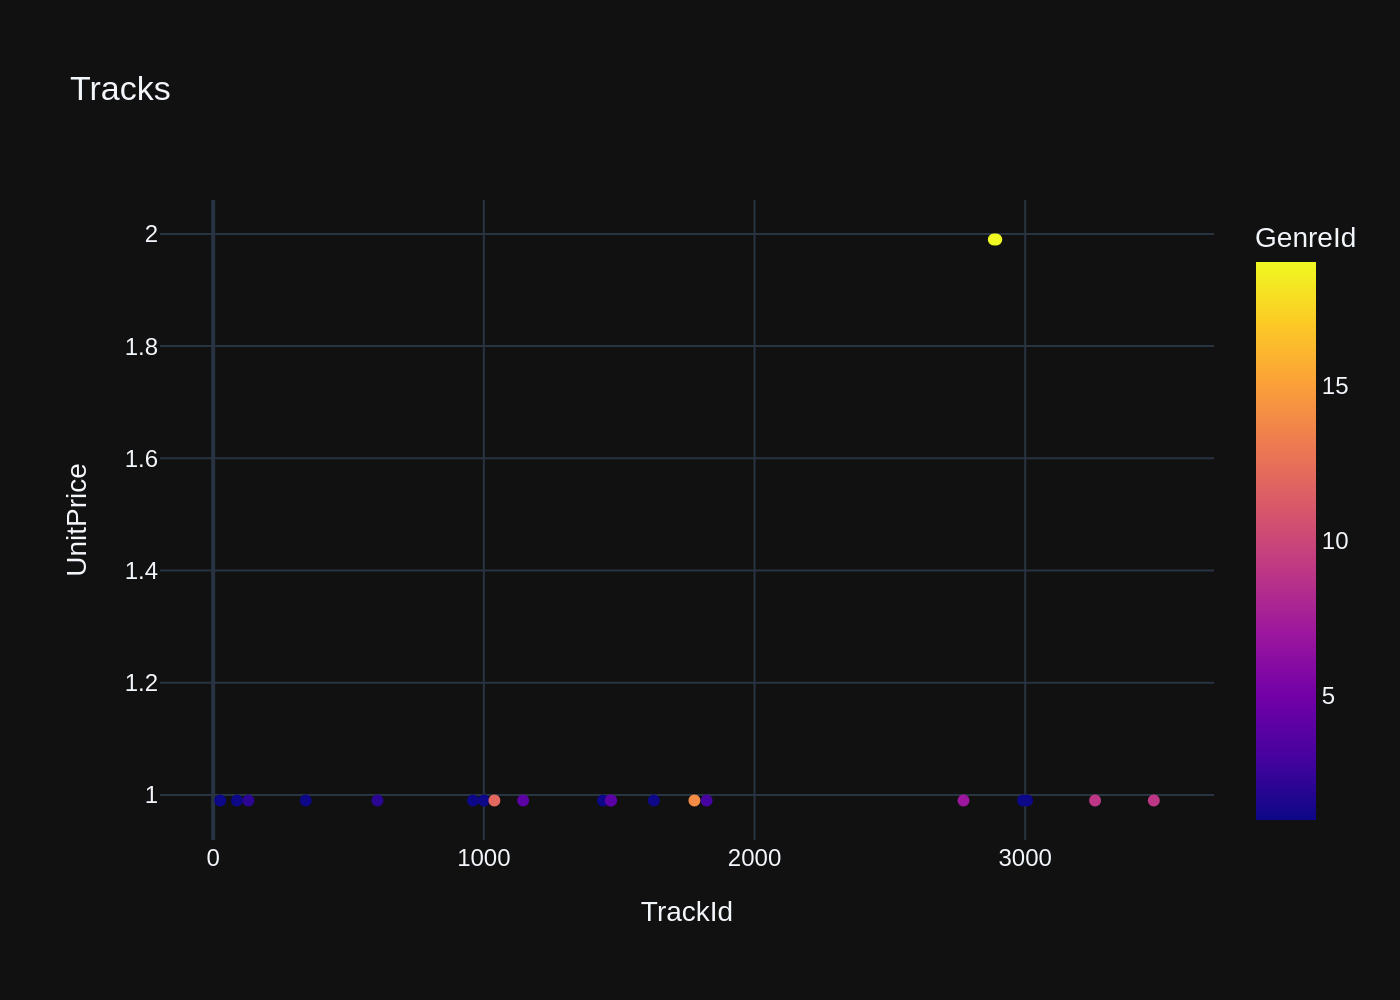

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 8:  Get the total number of invoices for each customer


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)\n\nCREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)\n\nCREATE TABLE "invoice

SELECT CustomerId, COUNT(*)
FROM invoices
GROUP BY CustomerId


[( DATA )]
queried dataframe


,CustomerId,COUNT(*)
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
5,6,7
6,7,7
7,8,7
8,9,7
9,10,7



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


fig = px.bar(df, x='CustomerId', y='COUNT(*)')

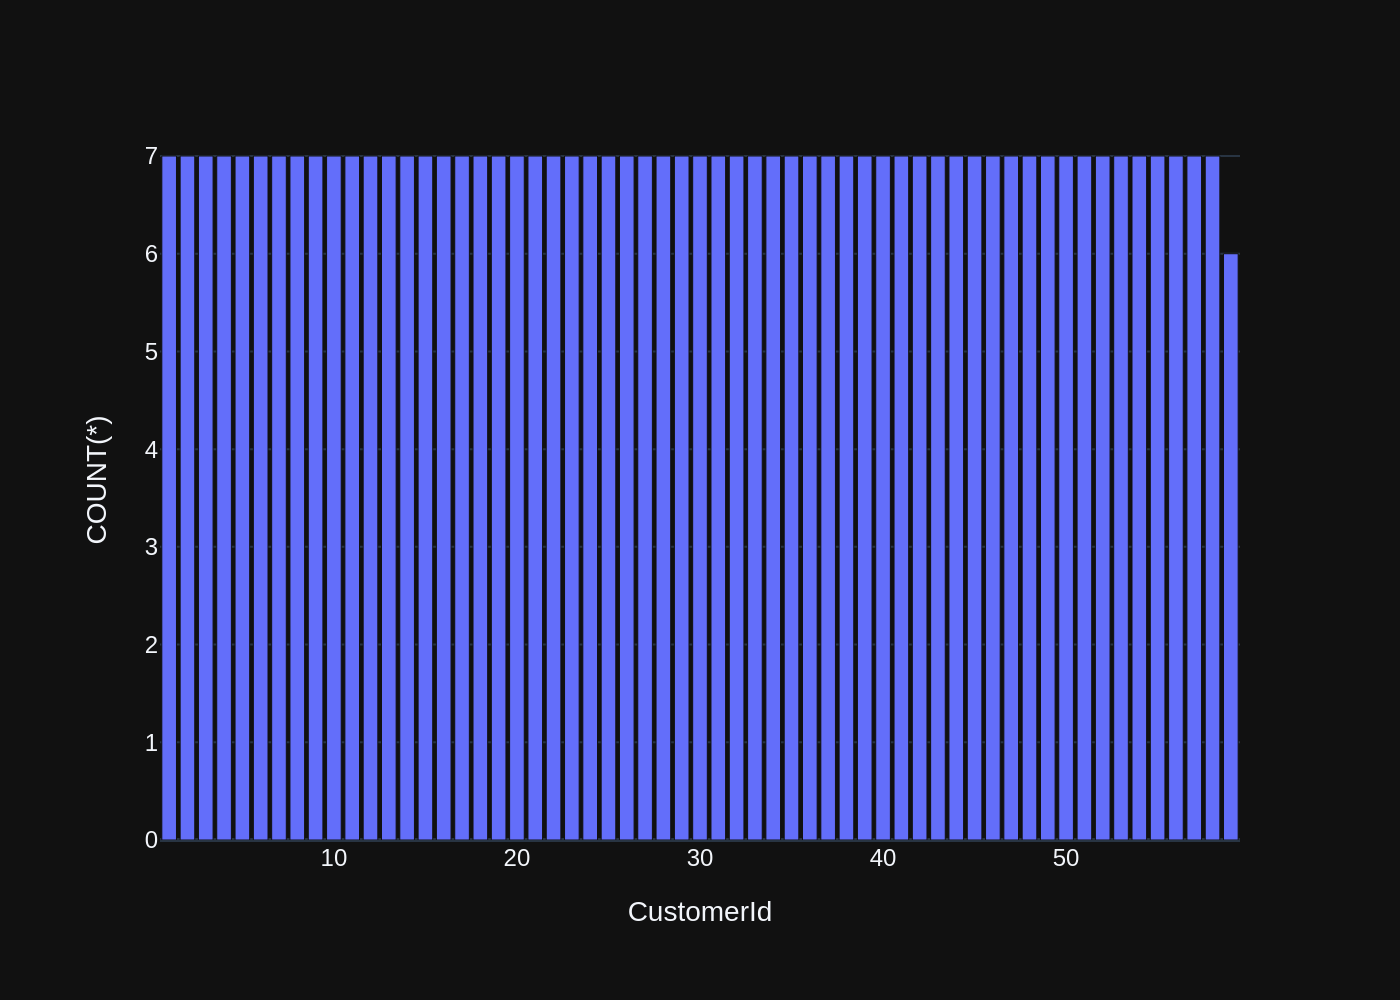

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 9:  Find the total number of invoices per country


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,

SELECTBillingCountry, COUNT(*) FROMinvoicesGROUP BYBillingCountry

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( RETRY )]
***** 1 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n    UnitPrice NUMERIC(10,2)  N

SELECT Country, COUNT(*) as TotalInvoices
FROM invoices
GROUP BY Country

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( RETRY )]
***** 2 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n    UnitPrice NUMERIC(10,2)  N

SELECT BillingCountry, COUNT(*) FROM invoices GROUP BY BillingCountry


[( DATA )]
queried dataframe


,BillingCountry,COUNT(*)
0,Argentina,7
1,Australia,7
2,Austria,7
3,Belgium,7
4,Brazil,35
5,Canada,56
6,Chile,7
7,Czech Republic,14
8,Denmark,7
9,Finland,7



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='BillingCountry', y='COUNT(*)')

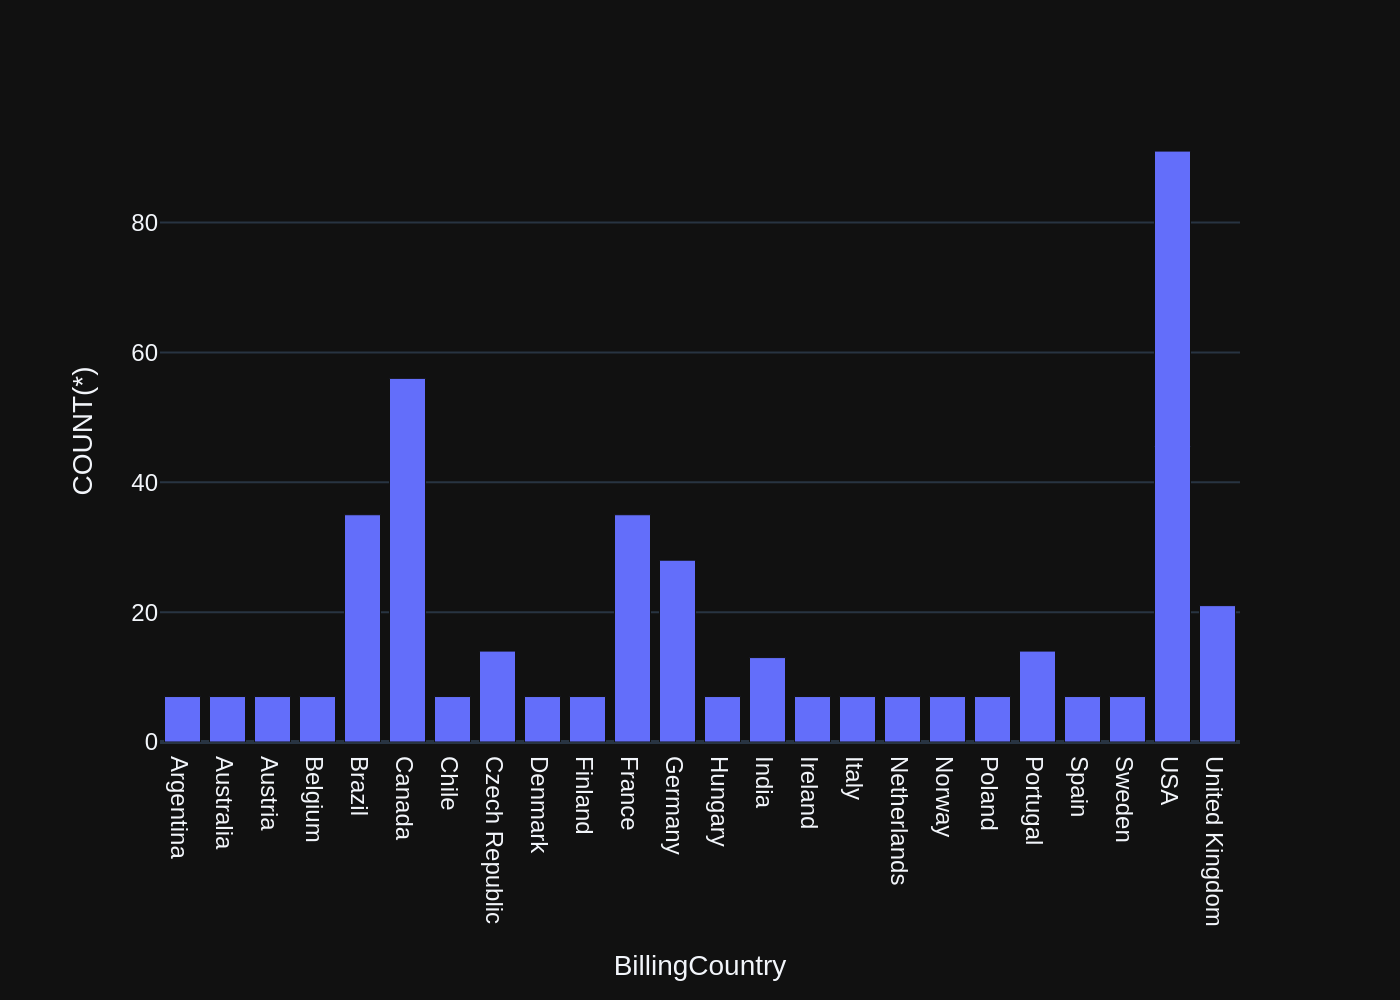

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 10:  List all invoices with a total exceeding $10


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    Quantity INTEGER  NOT NULL,\r\n    FOREIGN KEY (InvoiceId) REFERENCES "invoices" (InvoiceId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)\n\nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT N

SELECT * FROM invoices WHERE Total > 10


[( DATA )]
queried dataframe


,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
...,...,...,...,...,...,...,...,...,...
59,383,10,2013-08-12 00:00:00,"Rua Dr. Falcão Filho, 155",São Paulo,SP,Brazil,01007-010,13.86
60,390,48,2013-09-12 00:00:00,Lijnbaansgracht 120bg,Amsterdam,VV,Netherlands,1016,13.86
61,397,27,2013-10-13 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,13.86
62,404,6,2013-11-13 00:00:00,Rilská 3174/6,Prague,None,Czech Republic,14300,25.86



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if len(df) > 1:
    fig = px.histogram(df, x='Total', nbins=20, title='Invoice Totals')
    
else:
    fig = px.indicator(df, value=df['Total'][0], title='Invoice Total', color='Total')

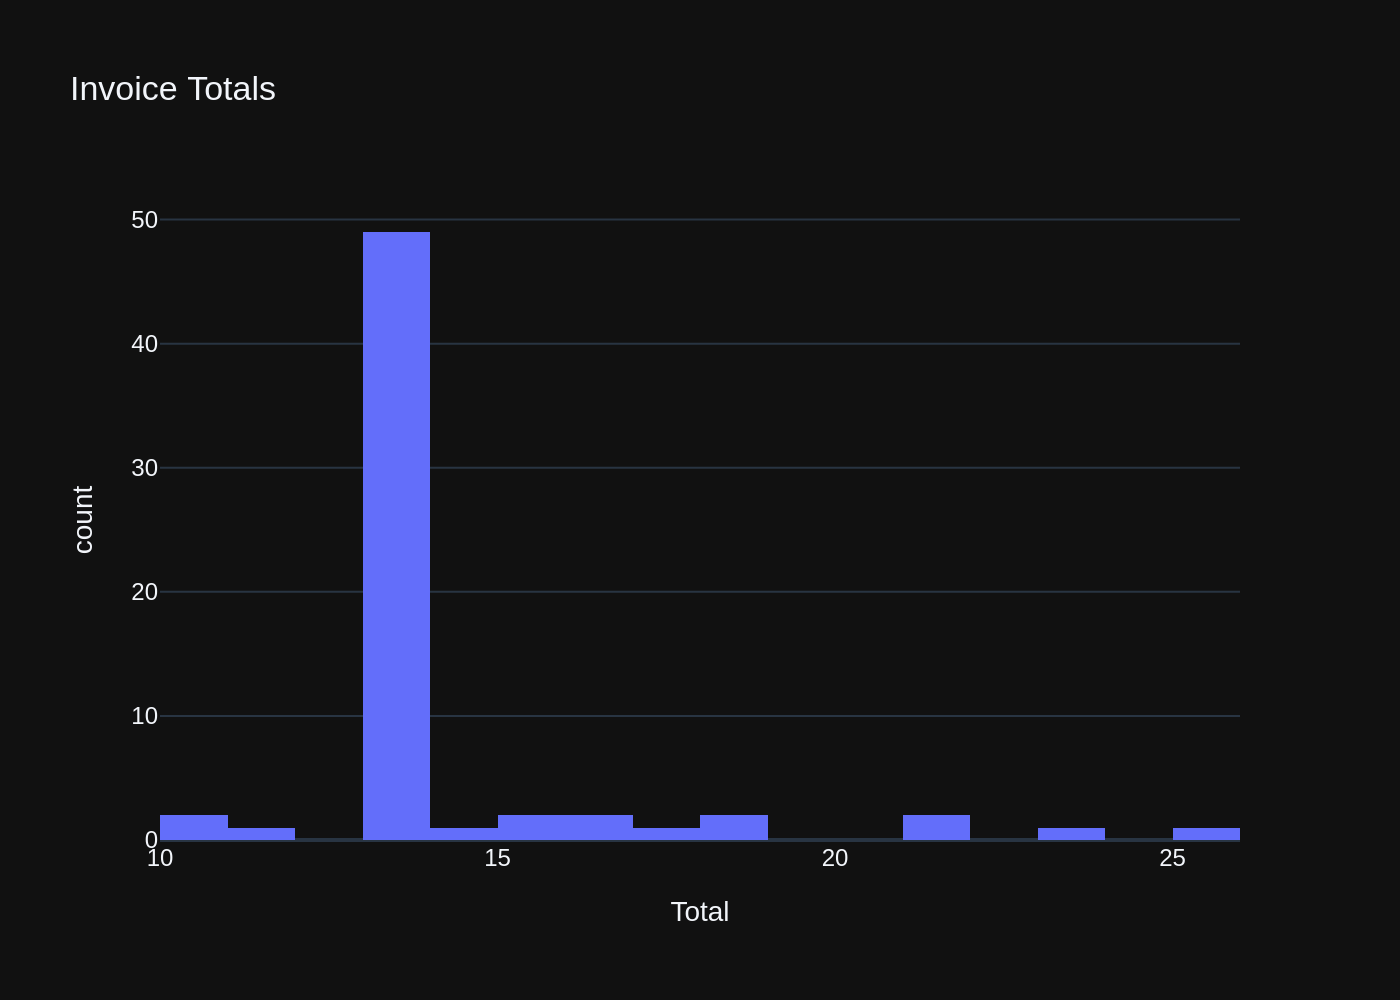

Number of requested results 10 is greater than number of elements in index 9, updating n_results = 9
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 11:  Find all invoices since 2010 and the total amount invoiced:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackI

SELECT InvoiceId, InvoiceDate, Total FROM invoices WHERE InvoiceDate >= '2010-01-01'


[( DATA )]
queried dataframe


,InvoiceId,InvoiceDate,Total
0,84,2010-01-08 00:00:00,1.98
1,85,2010-01-08 00:00:00,1.98
2,86,2010-01-09 00:00:00,3.96
3,87,2010-01-10 00:00:00,6.94
4,88,2010-01-13 00:00:00,17.91
...,...,...,...
324,408,2013-12-05 00:00:00,3.96
325,409,2013-12-06 00:00:00,5.94
326,410,2013-12-09 00:00:00,8.91
327,411,2013-12-14 00:00:00,13.86



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='InvoiceDate', y='Total')

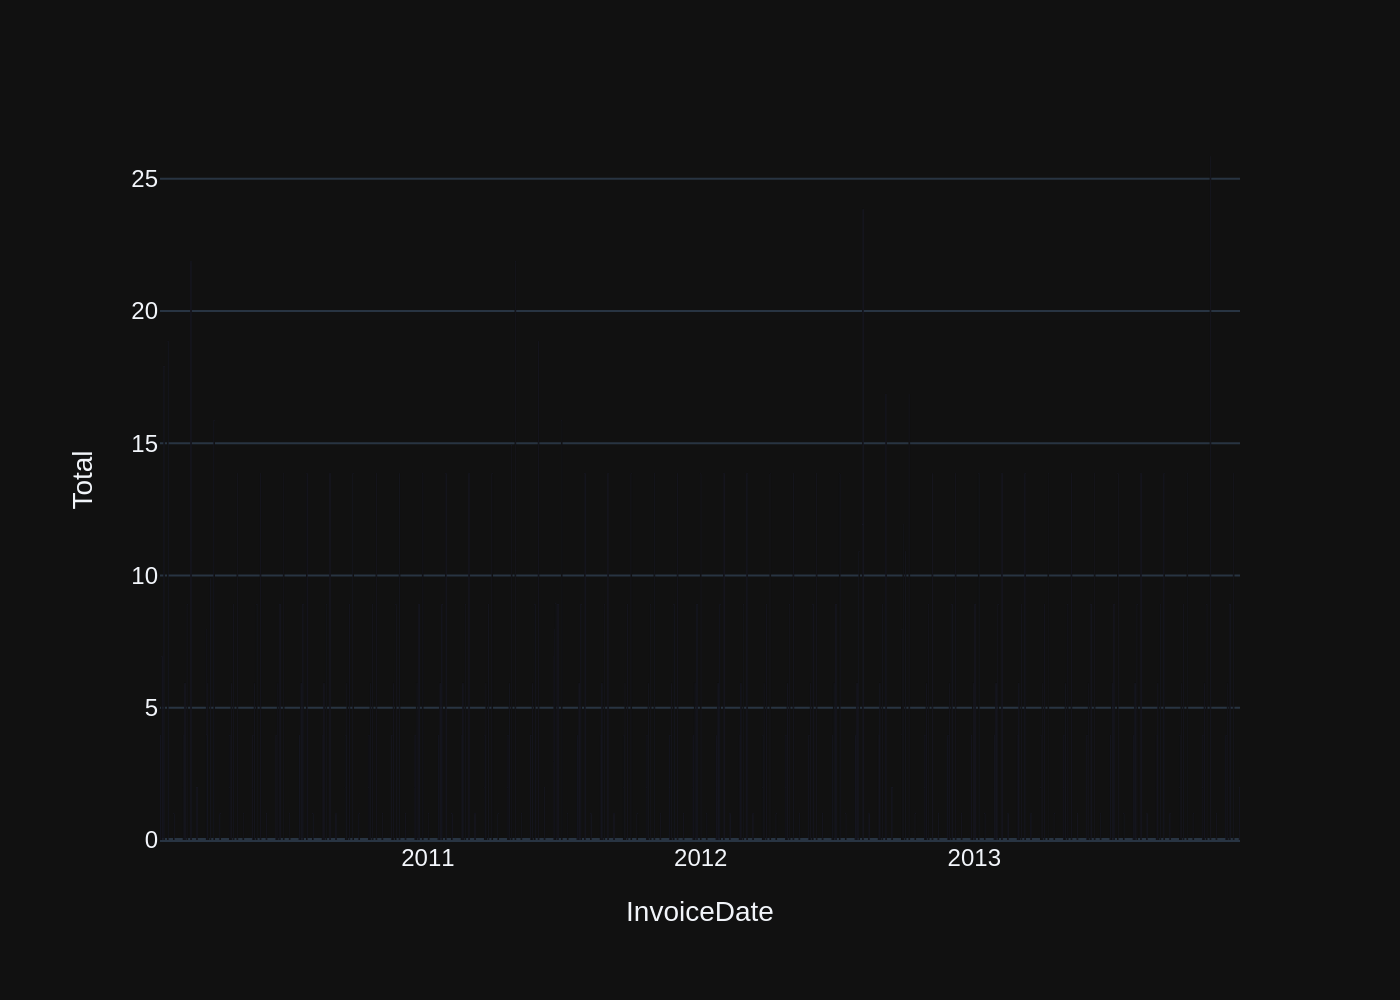

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 12:  List all employees and their reporting manager's name (if any):


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_EmployeeReportsTo ON "employees" (ReportsTo)\n\nCREATE TABLE "employees"\r\n(\r\n    EmployeeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    LastName NVARCHAR(20)  NOT NULL,\r\n    FirstName NVARCHAR(20)  NOT NULL,\r\n    Title NVARCHAR(30),\r\n    ReportsTo INTEGER,\r\n    BirthDate DATETIME,\r\n    HireDate DATETIME,\r\n    Address NVARCHAR(70),\r\n    City NVARCHAR(40),\r\n    State NVARCHAR(40),\r\n    Country NVARCHAR(40),\r\n    PostalCode NVARCHAR(10),\r\n    Phone NVARCHAR(24),\r\n    Fax NVARCHAR(24),\r\n    Email NVARCHAR(60),\r\n    FOREIGN KEY (ReportsTo) REFERENCES "employees" (EmployeeId) \r\n\t\tON DELETE

SELECT e.FirstName AS EmployeeFirstName,
       e.LastName AS EmployeeLastName,
       m.FirstName AS ManagerFirstName,
       m.LastName AS ManagerLastName
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId


[( DATA )]
queried dataframe


,EmployeeFirstName,EmployeeLastName,ManagerFirstName,ManagerLastName
0,Andrew,Adams,None,None
1,Nancy,Edwards,Andrew,Adams
2,Jane,Peacock,Nancy,Edwards
3,Margaret,Park,Nancy,Edwards
4,Steve,Johnson,Nancy,Edwards
5,Michael,Mitchell,Andrew,Adams
6,Robert,King,Michael,Mitchell
7,Laura,Callahan,Michael,Mitchell



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if df.shape[0] > 1:
    fig = px.scatter(df, x='EmployeeLastName', y='ManagerLastName',
                     color='ManagerFirstName')
    
else:
    fig = px.indicator(df, title='Employee', measure='ManagerLastName')

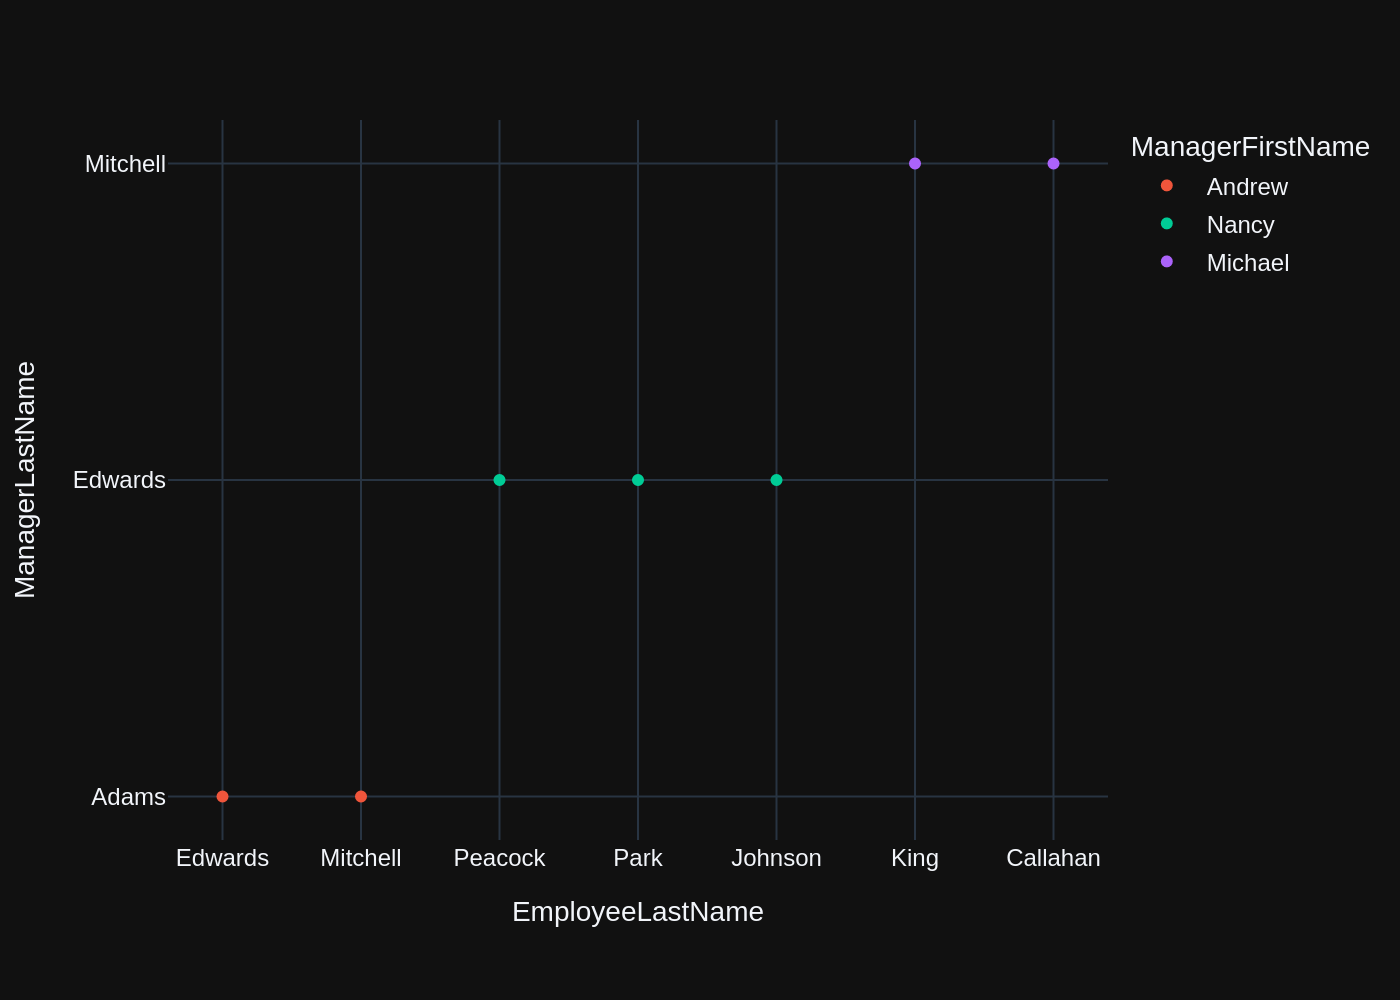

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 13:   Get the average invoice total for each customer:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)\n\nCREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)\n\nCREATE TABLE "invoice

SELECT CustomerId, AVG(Total) AS AvgInvoiceTotal FROM invoices GROUP BY CustomerId


[( DATA )]
queried dataframe


,CustomerId,AvgInvoiceTotal
0,1,5.660000
1,2,5.374286
2,3,5.660000
3,4,5.660000
4,5,5.802857
5,6,7.088571
6,7,6.088571
7,8,5.374286
8,9,5.374286
9,10,5.374286



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='CustomerId', y='AvgInvoiceTotal')

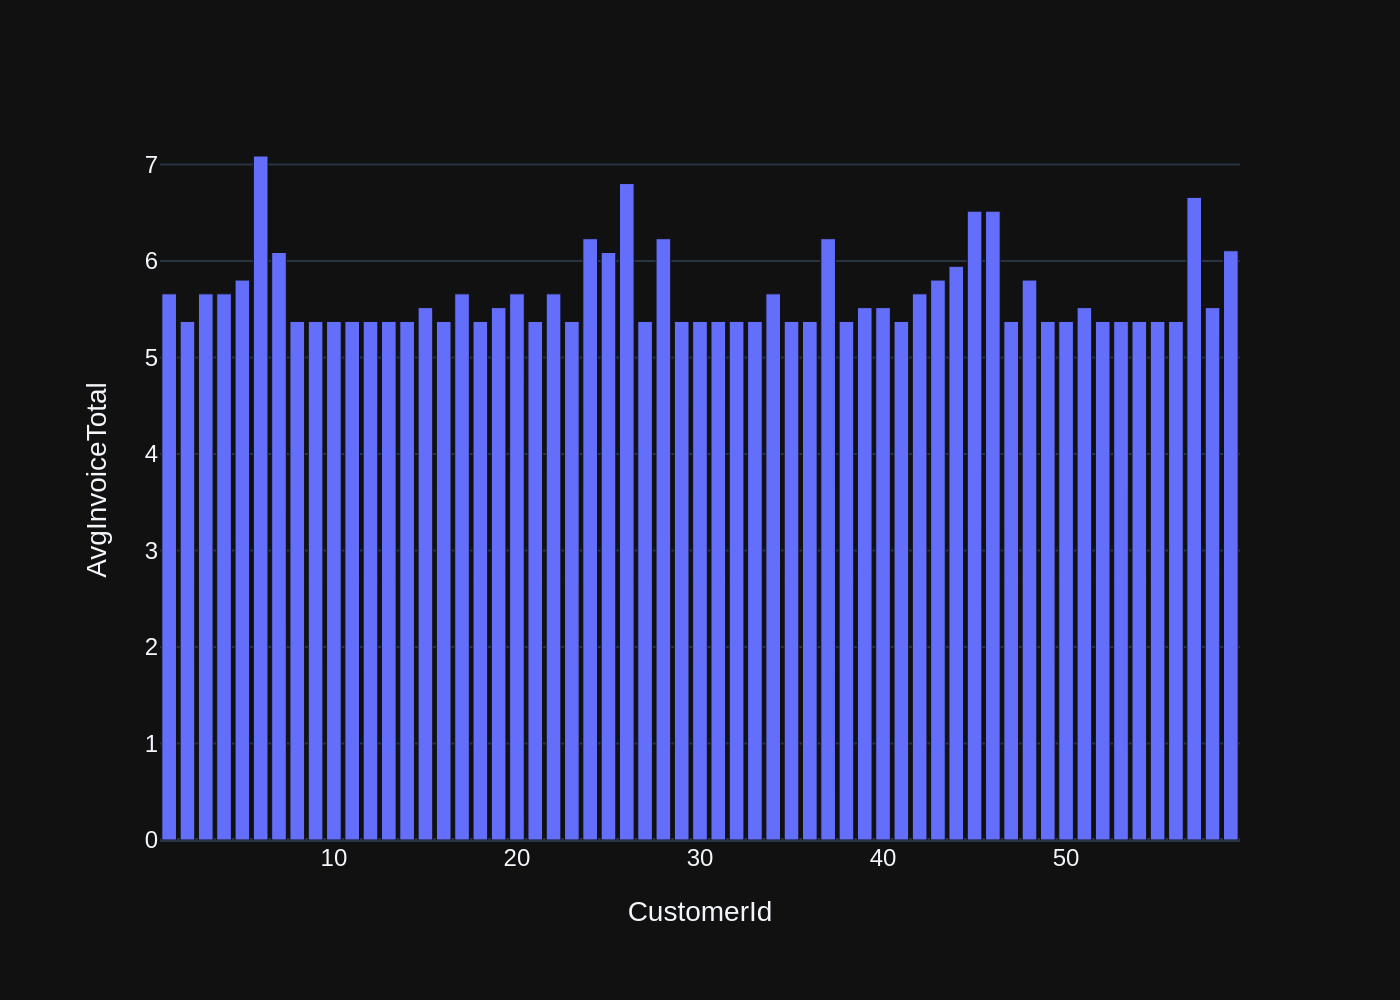

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 14:  Find the top 5 most expensive tracks (based on unit price):


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeId) \r\n\t\tON DELETE NO AC

SELECT TrackId, Name, UnitPrice FROM tracks ORDER BY UnitPrice DESC LIMIT 5


[( DATA )]
queried dataframe


,TrackId,Name,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,1.99
1,2820,Occupation / Precipice,1.99
2,2821,"Exodus, Pt. 1",1.99
3,2822,"Exodus, Pt. 2",1.99
4,2823,Collaborators,1.99



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='TrackId', y='UnitPrice', title='Top 5 Most Expensive Tracks')

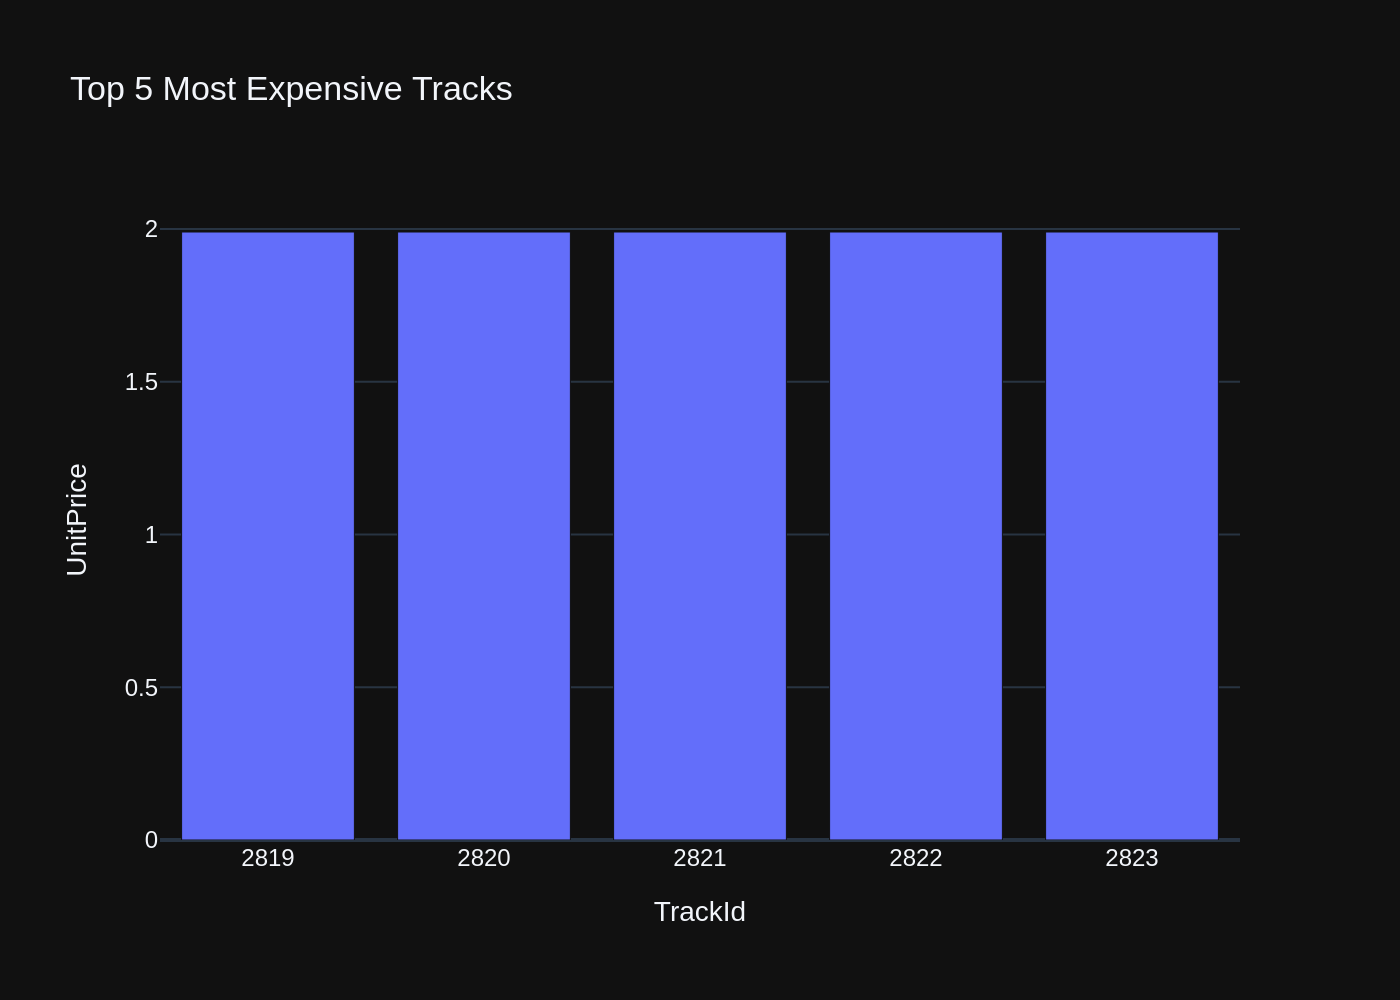

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 15:  List all genres and the number of tracks in each genre:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeId) \r\n\t\tON DELETE NO ACTION

SELECT g.Name AS GenreName, COUNT(t.TrackId) AS TrackCount
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId


[( DATA )]
queried dataframe


,GenreName,TrackCount
0,Rock,1297
1,Jazz,130
2,Metal,374
3,Alternative & Punk,332
4,Rock And Roll,12
5,Blues,81
6,Latin,579
7,Reggae,58
8,Pop,48
9,Soundtrack,43



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if len(df) == 1:
    fig = px.gauge(df, title='Number of Tracks')
else:
    fig = px.bar(df, x="GenreName", y="TrackCount")

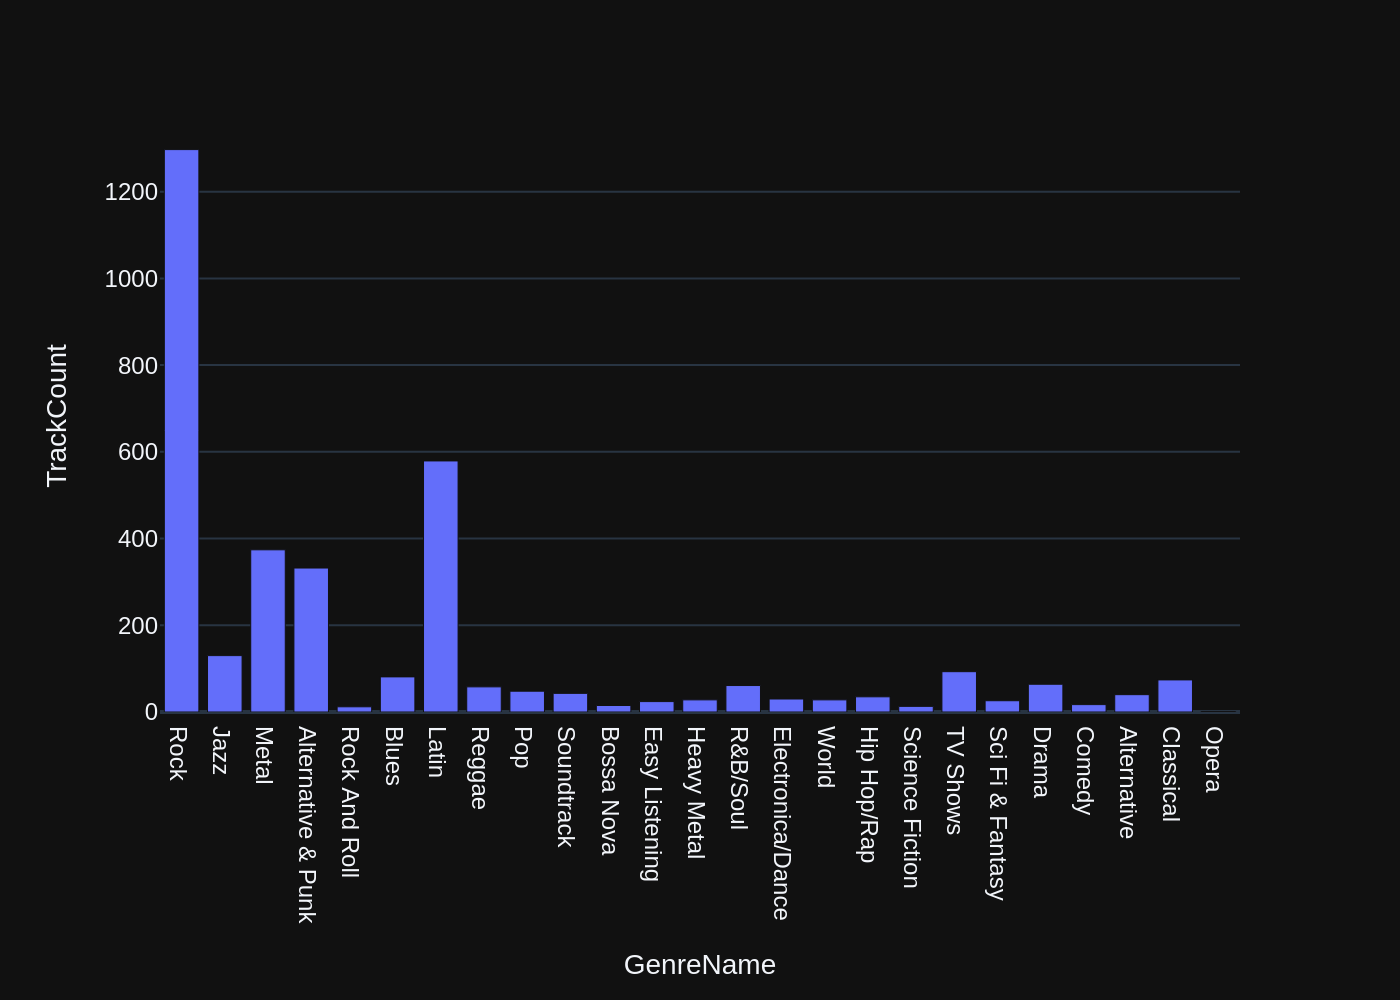

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 16:  Get all genres that do not have any tracks associated with them:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_TrackGenreId ON "tracks" (GenreId)\n\nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (MediaTypeId) RE

SELECT g.GenreId, g.Name FROM genres g LEFT JOIN tracks t ON g.GenreId = t.GenreId WHERE t.TrackId IS NULL


[( DATA )]
queried dataframe


,GenreId,Name


Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 17:  List all customers who have not placed any orders:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "customers"\r\n(\r\n    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    FirstName NVARCHAR(40)  NOT NULL,\r\n    LastName NVARCHAR

SELECT * FROM customers WHERE customer_id NOT IN (SELECT DISTINCT customer_id FROM invoices)

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( RETRY )]
***** 1 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "customers"\r\n(\r\n    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    FirstName NVARCHAR(40)  NOT NULL,\r\n    LastName NVARCHAR(20)  NOT NULL,\r\n    Company NVARCHAR(80),\

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( RETRY )]
***** 2 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n    UnitPrice NUMERIC(10,2)  N

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOR

SELECT a.ArtistId, COUNT(t.TrackId) as NumTracks
FROM artists a
JOIN albums alb ON a.ArtistId = alb.ArtistId
JOIN tracks t ON alb.AlbumId = t.AlbumId
GROUP BY a.ArtistId
ORDER BY NumTracks DESC
LIMIT 10


[( DATA )]
queried dataframe


,ArtistId,NumTracks
0,90,213
1,150,135
2,22,114
3,50,112
4,58,92
5,149,92
6,118,67
7,100,57
8,21,56
9,156,53



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


fig = px.bar(df, x='ArtistId', y='NumTracks')

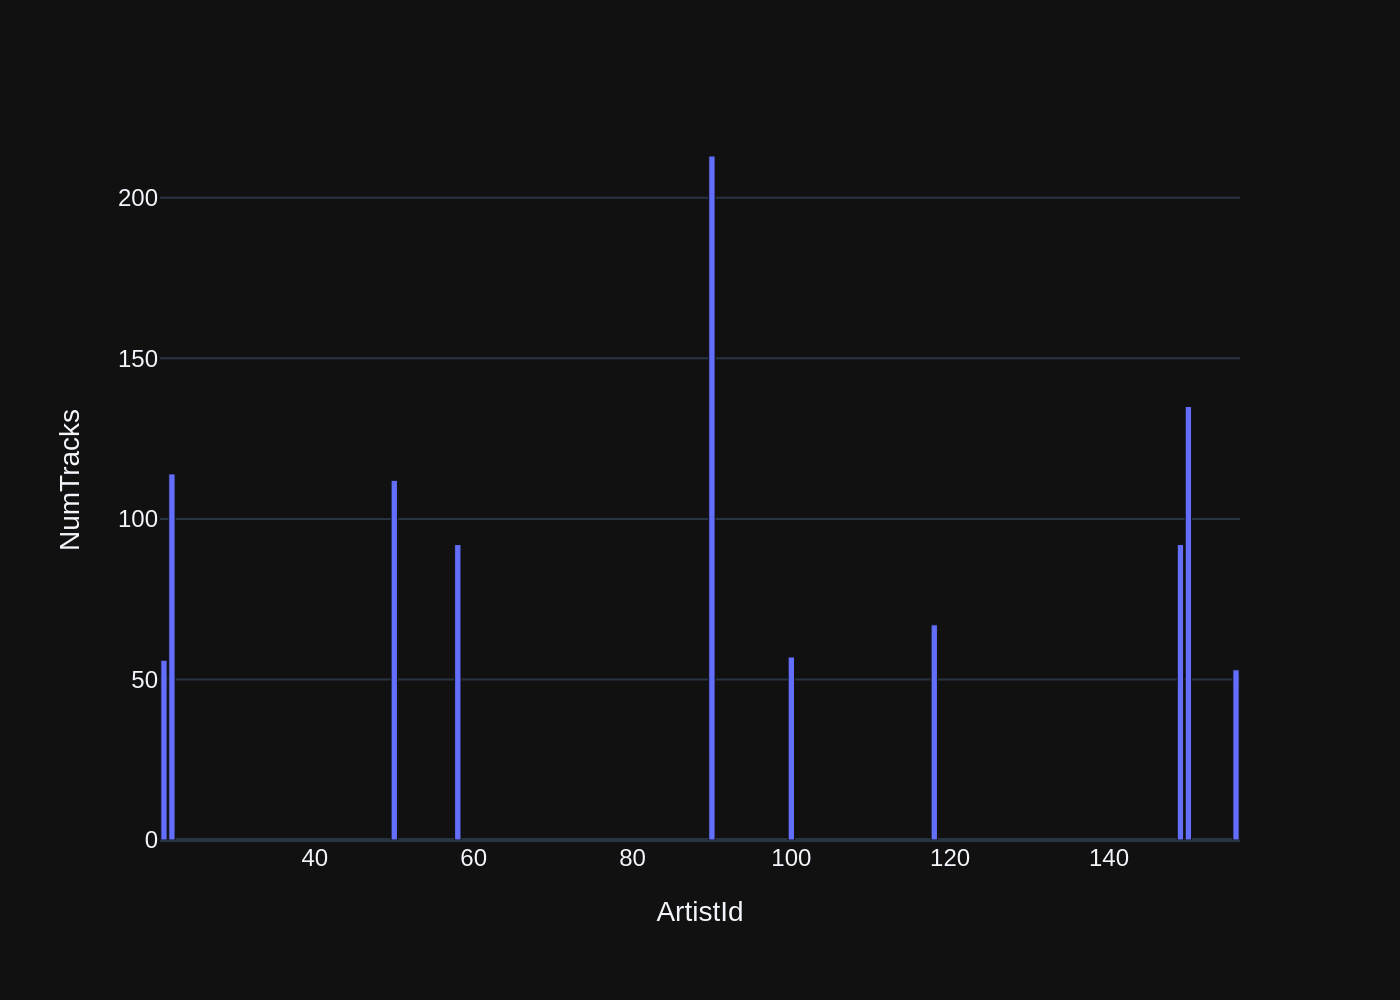

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 19:  List all customers from Canada and their email addresses:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_CustomerSupportRepId ON "customers" (SupportRepId)\n\nCREATE TABLE "customers"\r\n(\r\n    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    FirstName NVARCHAR(40)  NOT NULL,\r\n    LastName NVARCHAR(20)  NOT NULL,\r\n    Company NVARCHAR(80),\r\n    Address NVARCHAR(70),\r\n    City NVARCHAR(40),\r\n    State NVARCHAR(40),\r\n    Country NVARCHAR(40),\r\n    PostalCode NVARCHAR(10),\r\n    Phone NVARCHAR(24),\r\n    Fax NVARCHAR(24),\r\n    Email NVARCHAR(60)  NOT NULL,\r\n    SupportRepId INTEGER,\r\n    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)

SELECT FirstName, LastName, Email FROM customers WHERE Country = 'Canada'


[( DATA )]
queried dataframe


,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if len(df) == 1:
    fig = px.scatter(df, x="FirstName", y="LastName", color="Email")
else:
    fig = px.scatter(df, x="FirstName", y="LastName", color="Country", title='Customer Distribution')

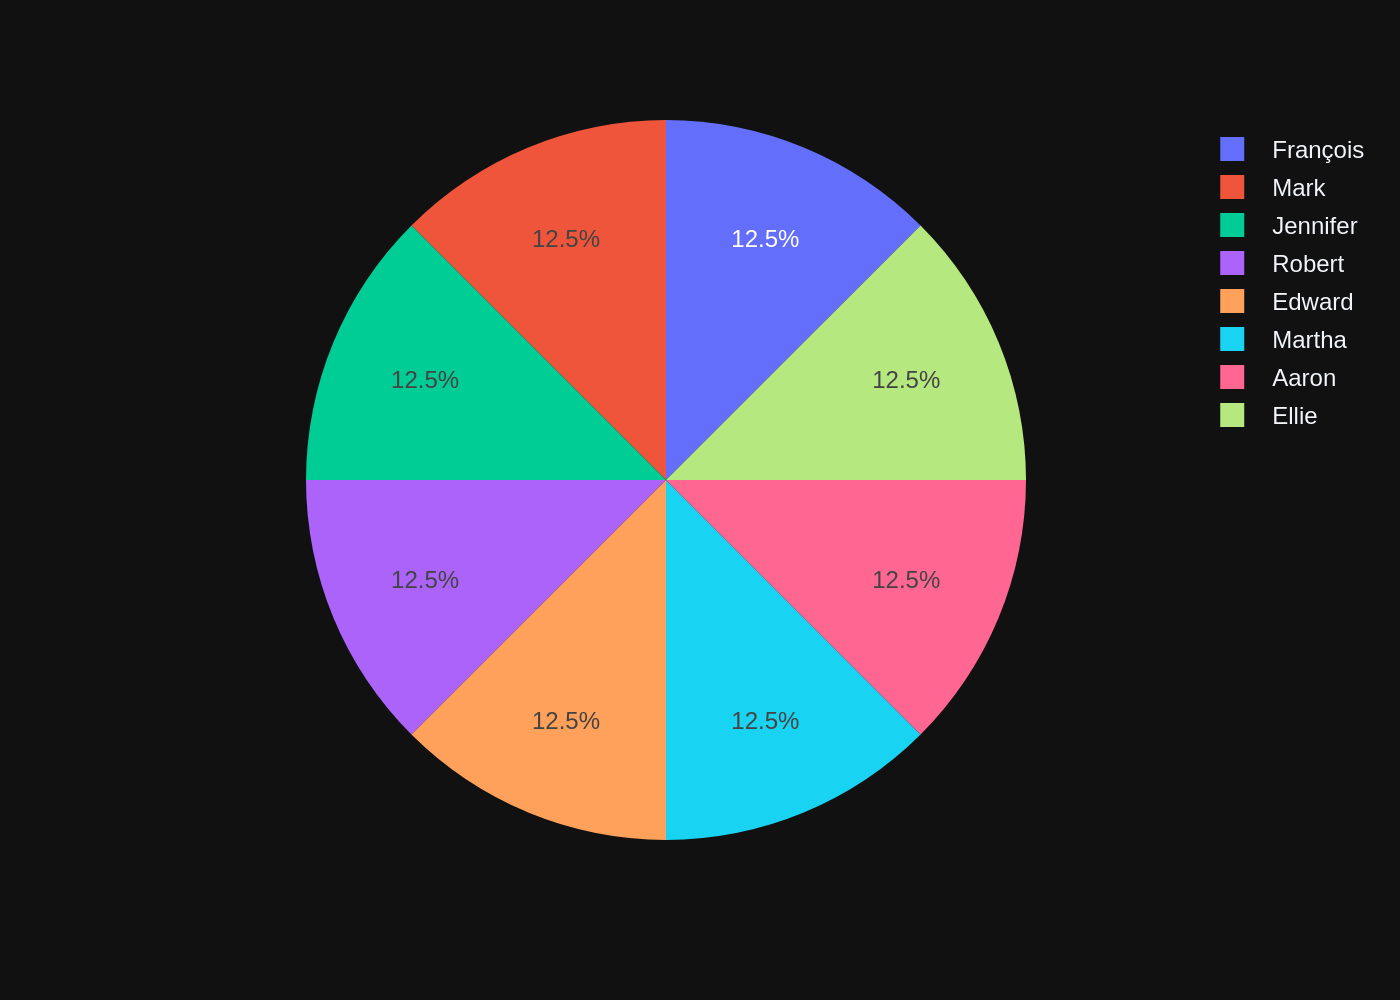

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 20:  Find the customer with the most invoices 


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)\n\nCREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)\n\nCREATE TABLE "invoice_items"\

SELECT CustomerId, COUNT(*) as TotalInvoices FROM invoices GROUP BY CustomerId ORDER BY TotalInvoices DESC LIMIT 1


[( DATA )]
queried dataframe


,CustomerId,TotalInvoices
0,1,7



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

if len(df) > 1:
    fig = px.bar(df, x='CustomerId', y='TotalInvoices')
    
else:
    fig = px.gauge(df, values=0, title=f'Customer {df["CustomerId"].values[0]} has {df["TotalInvoices"].values[0]} invoices')

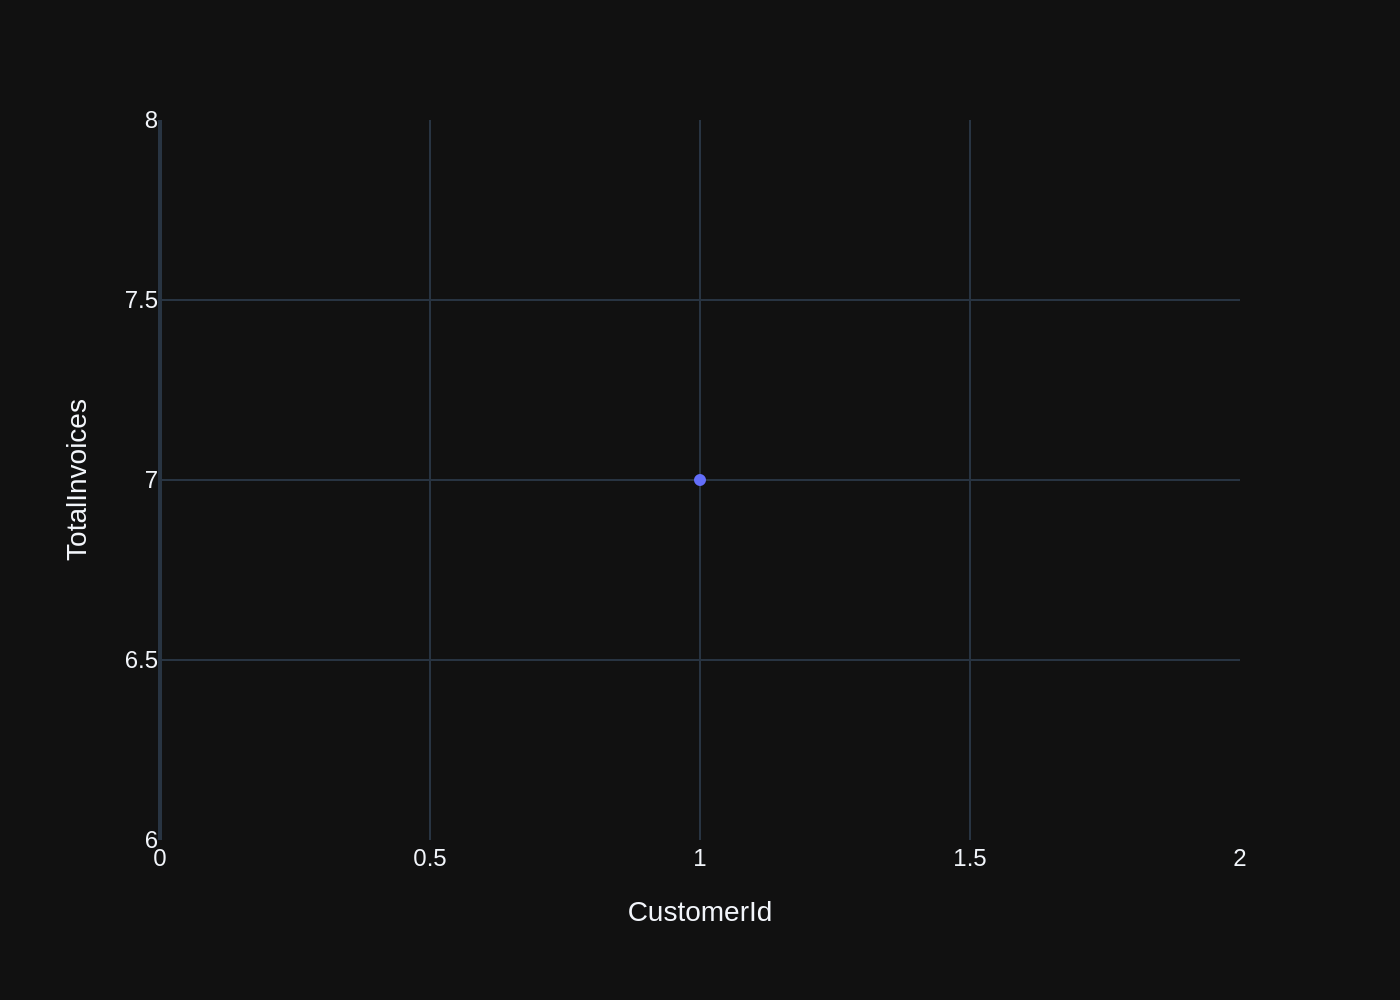

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeI

SELECT c.CustomerId, COUNT(ii.TrackId) AS TotalAlbumsBought FROM customers c JOIN invoices i ON c.CustomerId = i.CustomerId JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId WHERE ii.TrackId IN (SELECT ta.TrackId FROM tracks ta JOIN albums a ON ta.AlbumId = a.AlbumId GROUP BY ta.TrackId) GROUP BY c.CustomerId ORDER BY TotalAlbumsBought DESC LIMIT 1


[( DATA )]
queried dataframe


,CustomerId,TotalAlbumsBought
0,58,38



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='CustomerId', y='TotalAlbumsBought', title='Top Album Buyer')

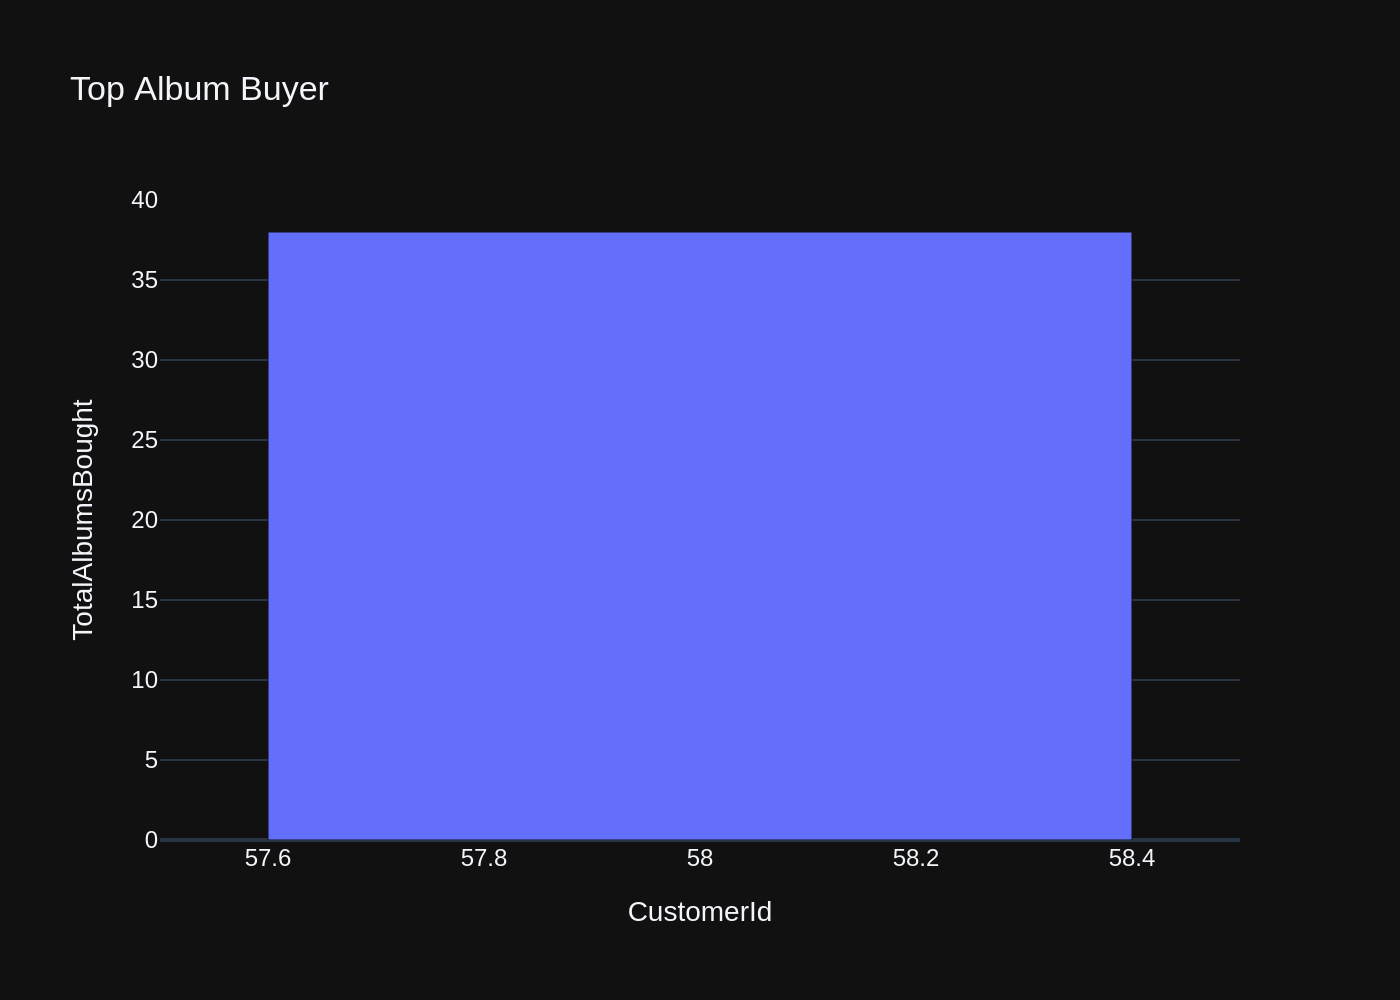

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoice_items"\r\n(\r\n    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    InvoiceId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    Quantity INTEGER  NOT NULL,\r\n    FOREIGN KEY (InvoiceId) REFERENCES "invoices" (InvoiceId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINC

SELECT
    i.CustomerId,
    COUNT(ii.TrackId) AS TotalAlbumsBought
FROM
    invoices i
JOIN
    invoice_items ii ON i.InvoiceId = ii.InvoiceId
GROUP BY
    i.CustomerId
ORDER BY
    TotalAlbumsBought DESC
LIMIT 5


[( DATA )]
queried dataframe


,CustomerId,TotalAlbumsBought
0,1,38
1,2,38
2,3,38
3,4,38
4,5,38



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='CustomerId', y='TotalAlbumsBought')

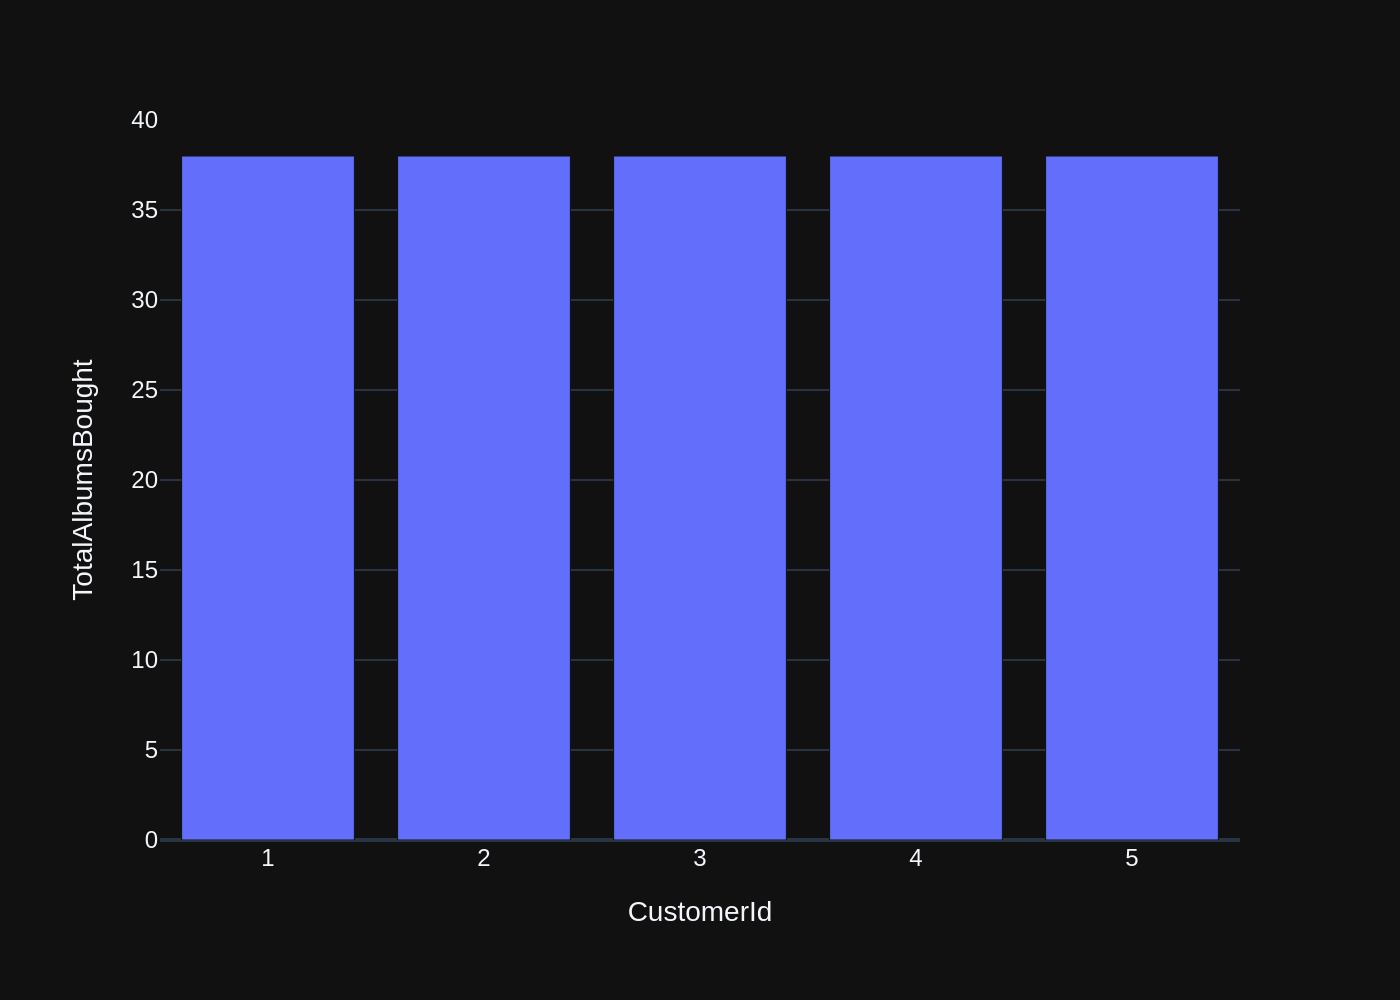

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "invoices"\r\n(\r\n    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    CustomerId INTEGER  NOT NULL,\r\n    InvoiceDate DATETIME  NOT NULL,\r\n    BillingAddress NVARCHAR(70),\r\n    BillingCity NVARCHAR(40),\r\n    BillingState NVARCHAR(40),\r\n    BillingCountry NVARCHAR(40),\r\n    BillingPostalCode NVARCHAR(10),\r\n    Total NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TAB

SELECT CustomerId, SUM(Total) AS TotalSpent FROM invoices GROUP BY CustomerId ORDER BY TotalSpent DESC LIMIT 5


[( DATA )]
queried dataframe


,CustomerId,TotalSpent
0,6,49.62
1,26,47.62
2,57,46.62
3,45,45.62
4,46,45.62



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


import plotly.express as px

fig = px.bar(df, x='CustomerId', y='TotalSpent')

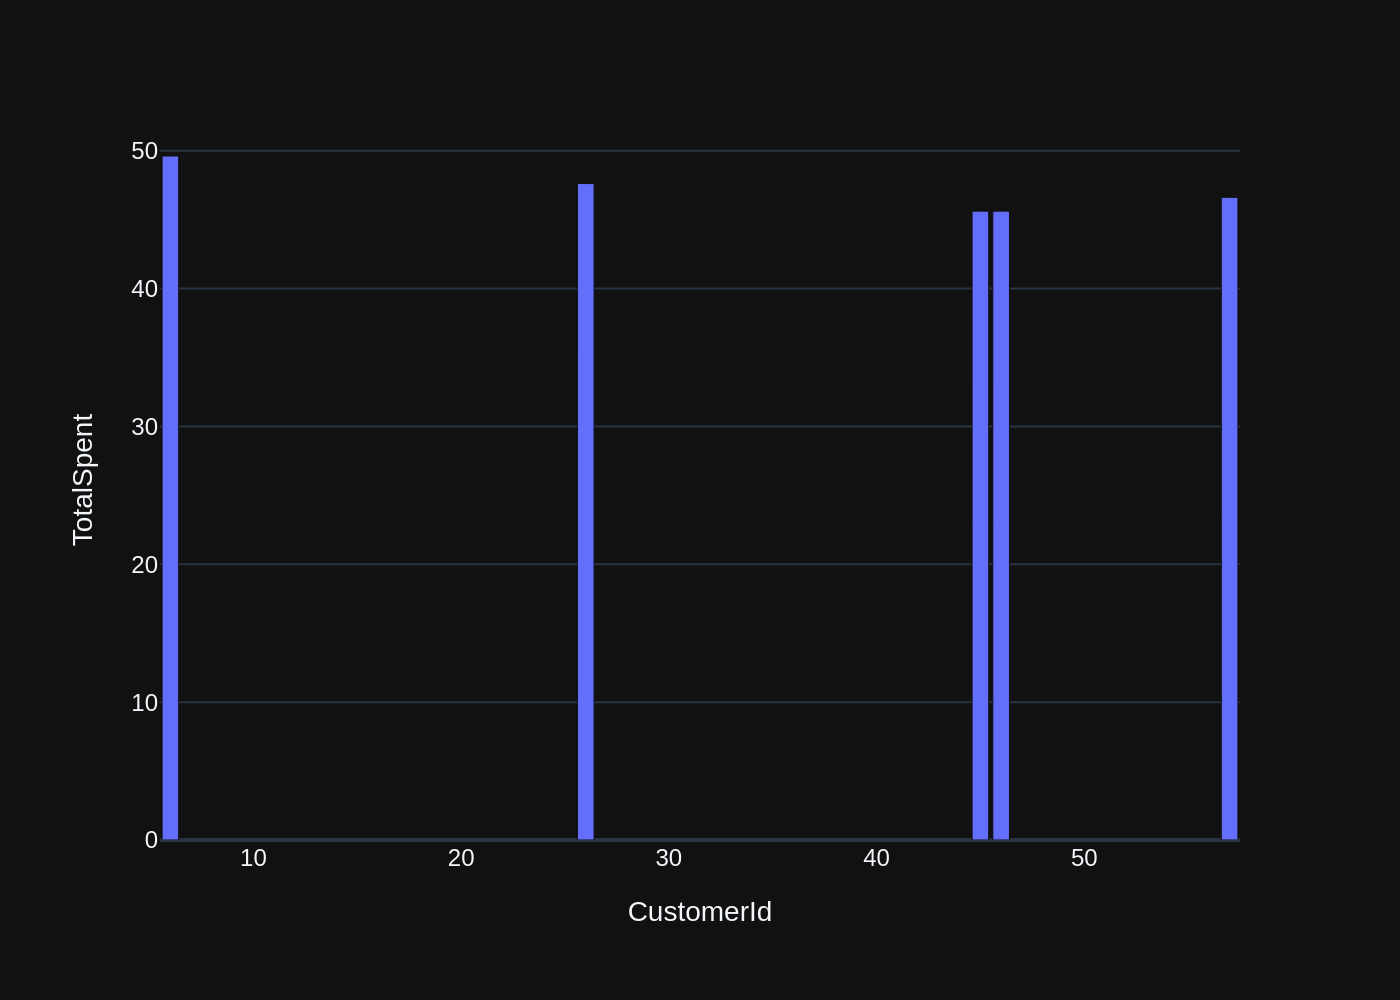

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_PlaylistTrackTrackId ON "playlist_track" (TrackId)\n\nCREATE TABLE "playlists"\r\n(\r\n    PlaylistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(120)\r\n)\n\nCREATE TABLE "playlist_track"\r\n(\r\n    PlaylistId INTEGER  NOT NULL,\r\n    TrackId INTEGER  NOT NULL,\r\n    CONSTRAINT PK_PlaylistTrack PRIMARY KEY  (PlaylistId, TrackId),\r\n    FOREIGN KEY (PlaylistId) REFERENCES "playlists" (PlaylistId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "tracks

SELECT p.Name AS PlaylistName, SUM(t.Milliseconds) AS TotalDuration FROM playlists p JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId JOIN tracks t ON pt.TrackId = t.TrackId GROUP BY p.PlaylistId HAVING COUNT(t.TrackId) >= 10


[( DATA )]
queried dataframe


,PlaylistName,TotalDuration
0,Music,877683083
1,TV Shows,501094957
2,90’s Music,398705153
3,Music,877683083
4,TV Shows,501094957
5,Brazilian Music,9486559
6,Classical,21770592
7,Classical 101 - Deep Cuts,6755730
8,Classical 101 - Next Steps,7575051
9,Classical 101 - The Basics,7439811



[( Ollama Parameters )]

      model=mistral-nemo:latest ,
      options={} ,
      keep_alive=None
    

[( PYTHON )]
generated Plotly code


fig = px.bar(df, x="PlaylistName", y="TotalDuration")

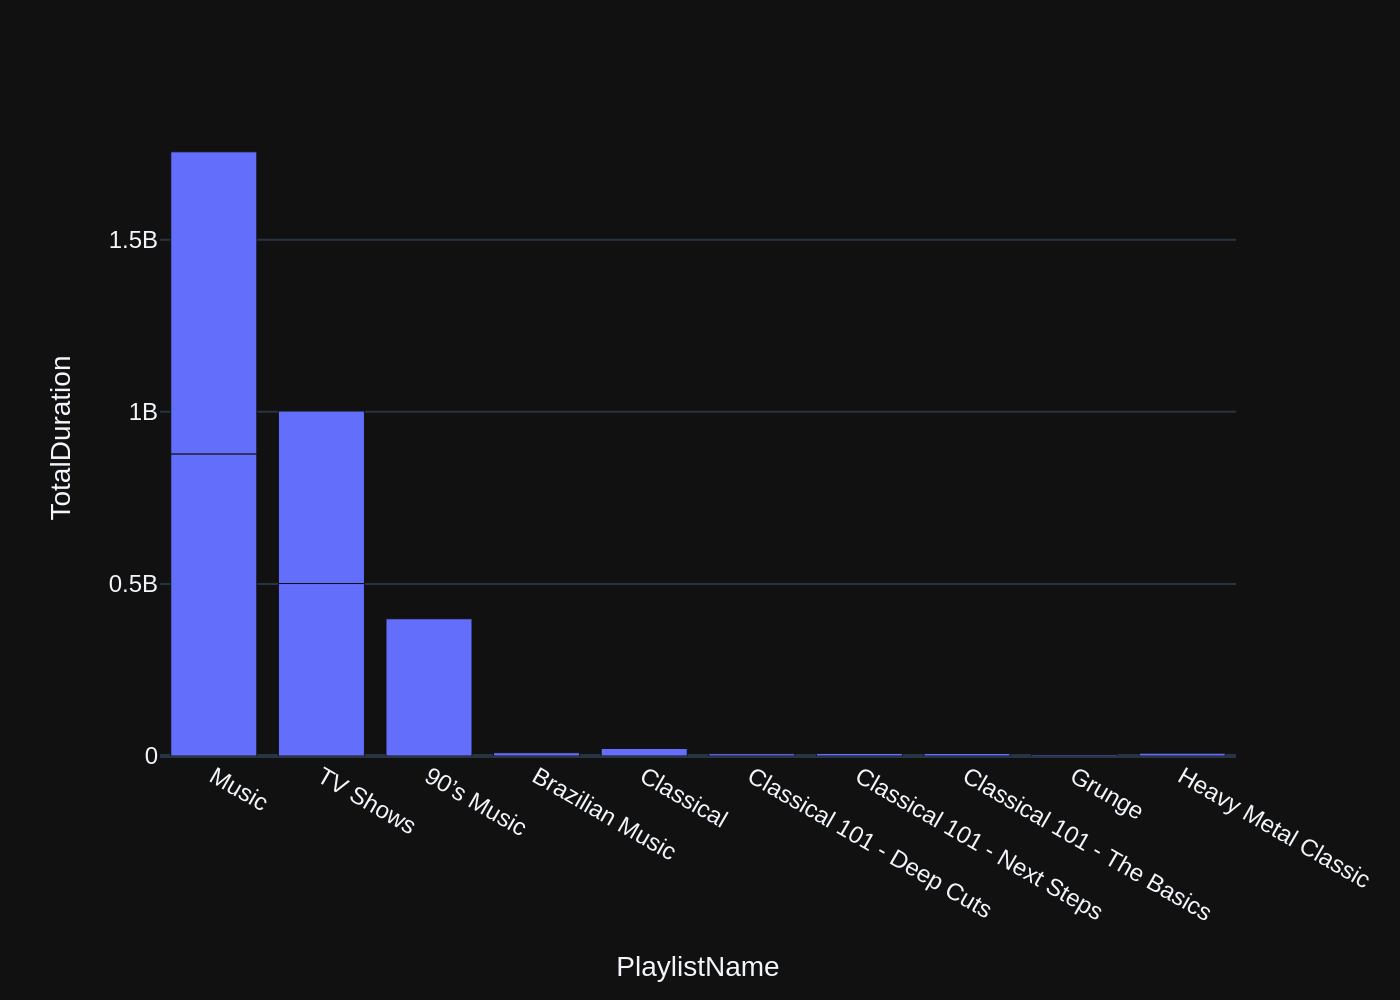

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 25:  Identify artists who have albums with tracks appearing in multiple genres:


[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeId) \r\n\t\t

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( LLM Response )]
intermediate_sql
SELECT DISTINCT GenreId FROM tracks GROUP BY GenreId HAVING COUNT(TrackId) > 1

final_sql
SELECT ArtistId FROM albums WHERE AlbumId IN (SELECT AlbumId FROM tracks WHERE GenreId IN (SELECT GenreId FROM tracks GROUP BY GenreId HAVING COUNT(TrackId) > 1))

[( Running Intermediate SQL )]
intermediate_sql
SELECT DISTINCT GenreId FROM tracks GROUP BY GenreId HAVING COUNT(TrackId) > 1

final_sql
SELECT ArtistId FROM albums WHERE AlbumId IN (SELECT AlbumId FROM tracks WHERE GenreId IN (SELECT GenreId FROM tracks GROUP BY GenreId HAVING COUNT(TrackId) > 1))

[( RETRY )]
***** 1 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( RETRY )]
***** 2 *****

[( SQL Prompt )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "tracks"\r\n(\r\n    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,\r\n    Name NVARCHAR(200)  NOT NULL,\r\n    AlbumId INTEGER,\r\n    MediaTypeId INTEGER  NOT NULL,\r\n    GenreId INTEGER,\r\n    Composer NVARCHAR(220),\r\n    Milliseconds INTEGER  NOT NULL,\r\n    Bytes INTEGER,\r\n    UnitPrice NUMERIC(10,2)  NOT NULL,\r\n    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\r\n    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeId) \r\n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\r\n)\n\nCREATE TABLE "genres"

In [14]:
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    vn.ask_adaptive(question=question, tag_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

### Check completion time

In [15]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'mistral-nemo' 
 took 6353 sec
 run on 'ducklover1' 
 at 20241013-154120


In [16]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-mistral-nemo-6353s-ducklover1-20241013-154120.csv'

### Save training data

In [17]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,049d362f-dfca-529e-ba7e-7d16e1ddaf33-sql,Get all playlists containing at least 10 track...,"SELECT p.Name AS PlaylistName, SUM(t.Milliseco...",sql
1,07a7f214-7ef1-52d4-b327-3e2f8cd9bd57-sql,\n For this question: which tab...,SELECT name FROM sqlite_master WHERE type='tab...,sql
2,146ba04e-dbac-58c0-b0c6-fe7b8c397c68-sql,Get the total number of invoices for each cust...,"SELECT CustomerId, COUNT(*)\nFROM invoices\nGR...",sql
3,21d4b292-07cb-51d4-ba89-6ac2bbc6b490-sql,what are the top 5 countries that customers co...,"SELECT country, COUNT(*) as num_customers\nFRO...",sql
4,256eeef7-aff7-59e7-bb8a-f2c361c407cf-sql,\n Find the top 5 customers who spen...,"SELECT CustomerId, SUM(Total) AS TotalSpent FR...",sql
5,26ba68ab-b932-5f22-89da-74029f5e0285-sql,Find the customer who bought the most albums i...,"SELECT c.CustomerId, COUNT(ii.TrackId) AS Tota...",sql
6,2f21bb39-7f91-5048-adac-9c721490ee39-sql,List all genres and the number of tracks in ea...,"SELECT g.Name AS GenreName, COUNT(t.TrackId) A...",sql
7,55774a9c-f87d-50a9-9502-0925f5638dc5-sql,\n Find the top 5 customers who b...,"SELECT\n i.CustomerId,\n COUNT(ii.TrackI...",sql
8,5e22f1a8-263e-5e39-a6c7-c9e07c831a7e-sql,Find the top 5 most expensive tracks (based on...,"SELECT TrackId, Name, UnitPrice FROM tracks OR...",sql
9,6304c034-7e76-5a53-b15d-da112977366d-sql,\n For this question: \n ...,"SELECT BillingCountry, COUNT(*) FROM invoices ...",sql


In [18]:
df_training_data.to_csv(file_csv, index=False)